After downloading the data from Mendeley Data (https://data.mendeley.com/datasets/zmwh6wxyv3/1),
assign the path for where the data folder is sitting to the variable ```data_path```. For example, ```data_path = "Users/Astro/Deskop/MK22_data_files"```. 

As indicated in our paper, we use the MW selection function from [Drlica Wagner et al. 2020](https://ui.adsabs.harvard.edu/abs/2020ApJ...893...47D/abstract). The selection function is available for downloading [here](https://github.com/des-science/mw-sats). After cloning the repository, assign its path to the ```mw_selection_function_path``` variable. For example, ```mw_selection_function_path = "Users/Astro/Deskop/mw-sats"```.  

In [2]:
data_path = ""

mw_selection_function_path = ""

In [170]:
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from astropy.coordinates import SkyCoord
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
from os.path import join,exists,isfile
import glob
import time
from os import listdir
import matplotlib.patheffects as pe
from scipy.stats import binned_statistic
from collections import OrderedDict as odict
from tqdm.notebook import tqdm
import yaml
from scipy import stats
import xgboost as xgb
import math
from matplotlib.ticker import MultipleLocator, FixedLocator, FormatStrFormatter
import numpy as np
import healpy as hp
from astropy.table import Table, Column, MaskedColumn
from astropy.io import ascii
from astropy import units as u
from astropy.coordinates import SkyCoord
from matplotlib.lines import Line2D
from bs4 import BeautifulSoup
from requests_html import HTMLSession
from urllib.parse import urljoin

#the constraints for MW mass withing 100 kpc are 
#5.6 \pm 0.4 e11


def plot_pretty(dpi=175,fontsize=9):
    # import pyplot and set some parameters to make plots prettier
    import matplotlib.pyplot as plt

    plt.rc("savefig", dpi=dpi)
    plt.rc("figure", dpi=dpi)
    plt.rc('text', usetex=True)
    plt.rc('font', size=fontsize)
    plt.rc('xtick', direction='in') 
    plt.rc('ytick', direction='in')
    plt.rc('xtick.major', pad=5) 
    plt.rc('xtick.minor', pad=5)
    plt.rc('ytick.major', pad=5) 
    plt.rc('ytick.minor', pad=5)
    plt.rc('lines', dotted_pattern = [0.5, 1.1])

    return

plot_pretty()

def perc975(x):
    return np.percentile(x,97.5)
def perc998(x):
    return np.percentile(x,99.8)
def perc002(x):
    return np.percentile(x,0.2)
def perc025(x):
    return np.percentile(x,2.5)
def perc023(data):
    return np.percentile(data,2.3)
def perc977(data):
    return np.percentile(data,97.7)
def perc159(data):
    return np.percentile(data,15.9)
def perc841(data):
    return np.percentile(data,84.1)

def get_shade(xdata,ydata,num_bins):
    """Return xbincenters,ymedian and percentiles"""
    
    #get the xdata and ydata and linearly interpolate between them 
#     xtr = np.linspace(np.min(xdata),np.max(xdata),1000)
#     ytr = np.interp(xtr, xdata[::-1], ydata[::-1])

    xtr = xdata
    ytr = ydata
    
    y_md,be, m = binned_statistic(xtr,ytr, statistic="median",   bins=num_bins)
    y_23,be, m = binned_statistic(xtr,ytr, statistic=perc023, bins=num_bins)
    y_977,be, m = binned_statistic(xtr,ytr, statistic=perc977, bins=num_bins)
    y_159,be, m = binned_statistic(xtr,ytr, statistic=perc159, bins=num_bins)
    y_841,be, m = binned_statistic(xtr,ytr, statistic=perc841, bins=num_bins)
    y_998,be, m = binned_statistic(xtr,ytr, statistic=perc998, bins=num_bins)
    y_002,be, m = binned_statistic(xtr,ytr, statistic=perc002, bins=num_bins)
    
    x_bins = (be[:-1]+be[1:])/2
    
    return x_bins, y_md, y_23,y_977, y_159, y_841, y_002,y_998

def get_linear_hist(xdata,oppo=True,minx = 0):
    
    xsort = np.sort(xdata)
    max_num = len(xdata)
    
    if oppo==True:
        xsort = xsort[::-1]
        xpts = [minx] + list(np.concatenate(list(zip(xsort,xsort))))
        numrange = np.arange(1,max_num+1)[::-1]
        ypts = list(np.concatenate(list(zip(numrange,numrange))  )) + [0]
        
    else:
        xpts = list(np.concatenate(list(zip(xsort,xsort)))) + [minx]
        numrange = np.arange(1,max_num+1)
        
        ypts = [0] + list(np.concatenate(list(zip(numrange,numrange))  ))
    
    
    return xpts,ypts
        


def nfw_fx(x):
    return np.log(1+x) - (x/(1+x))

def compute_mass_100(mvir,rvir,rs):
    '''
    Function that computes the mass enclosed within 100kpc of the host center assuming an NFW profile.
    '''
    
    c = rvir/rs
    
    x = 100/rvir #100kpc enclosed mass
    
    menc = mvir * nfw_fx(c*x) / nfw_fx(c)
    
    return menc

mw_data = np.loadtxt("miscel_files/drlica_wagner20_tab2_read.txt",dtype="str")
all_mw_mags = mw_data[:,10].astype(float) 
all_mw_class = mw_data[:,2].astype(float) 
all_mw_r12 = mw_data[:,9].astype(float)
all_mw_heliods = mw_data[:,8].astype(float)
all_mw_ras = mw_data[:,3].astype(float)
all_mw_decs = mw_data[:,4].astype(float)
all_names = mw_data[:,0]




all_surfs_data = all_mw_mags[all_mw_class != 2] + 21.5721 + 2.5*np.log10(2*np.pi*all_mw_r12[all_mw_class != 2]**2)


all_mw_mags = all_mw_mags[all_mw_class != 2]
all_mw_r12 = all_mw_r12[all_mw_class != 2]
all_mw_heliods = all_mw_heliods[all_mw_class != 2]
all_mw_ras = all_mw_ras[all_mw_class != 2]
all_mw_decs = all_mw_decs[all_mw_class != 2]
all_names = all_names[all_mw_class != 2]

In [81]:
def convert_to_helio(xc,yc,zc):
    '''
    Function that converts to heliocentric frame by randomizing the location of the sun.
    xc[0], yc[0],zc[0] must be location of the host galaxy center so must be 0,0,0
    
    
    '''
    
    #host is at 0,0,0
    #the distance of Sun from MW center is assumed to be 8 kpc.
    #for sun's position generate a random co-ordinate on the surface 
    #of a sphere with radius 8 Kpc with host as center (0,0,0). The position of point
    #automatically constraints the disk. So it is as if we are choosing a random disk orientation

    x_sun = []
    
    theta = 2*np.pi*np.random.uniform(0,1)
    phi = np.arccos(1 - 2*np.random.uniform(0,1))
    x_sun = 8*np.sin(phi) * np.cos(theta)
    y_sun = 8*np.sin(phi) * np.sin(theta)
    z_sun = 8*np.cos(phi)
    #reposition such that sun is now at center
    #we originally have coordinates in galactocentric frame 
    
    if xc[0] != 0 or yc[0] != 0 or zc[0] != 0:
        print("Host center issue in convert_to_helio funtion")
    
    xnew = xc - x_sun
    ynew = yc - y_sun
    znew = zc - z_sun
    #now, we will convert to galactic co-ordinates L and B
    #in galactic coordinate frame which is centered at Sun. Galaxy center is at (R,0,0)
    heliods = np.sqrt(xnew**2 + ynew**2 + znew**2) #all distances of subhalos from Sun
    
    return xnew, ynew, znew, heliods

def get_ra_dec(xc,yc,zc):
    '''
    Function that takes in HELIOCENTRIC cartesian coordinates and returns the coordinates
    in equatorial coordinate system (RA, Dec) by assuming random MW disk orientations (aka position of Sun).
    
    The coordinates of the host are not needed here as the coordinates transformation to center of sun
    has already been done. 
    
    This has been confirmed to work by cross checking with Nadler's code on his github repository
    
    '''    
    
    #construct the SkyCoord object     
    all_sats = SkyCoord(x = xc, y=yc, z=zc,unit = "kpc",representation_type = "cartesian")
    #convert to equatorial frame in RA and DEC
    all_sats =all_sats.fk5
    ra_f = all_sats.ra.value
    dec_f = all_sats.dec.value
    return ra_f,dec_f

def transform_to_sky_coords(xc,yc,zc):
    '''
    This function is from Nadler's github code. This works the exact same way as get_ra_dec function above that I wrote.
    '''
    Halo_sky_coord = SkyCoord(x=xc,y=yc,z=zc,
                              unit='kpc',representation_type='cartesian').spherical
    return Halo_sky_coord.lon.degree, Halo_sky_coord.lat.degree

#functions for rotating to LMC coordinates 
def do_rotation(all_pos,vec1,vec2):
    """
    Returns heliocentric satellite position vectors transformed via a rotation matrix that rotates the mock LMC analog into its correct sky position
    Args:
    all_pos (array): (N,3) array of heliocentric satellite positions in cartesian coordinates
    vec1 (array): original cartesian heliocentric coordinates of mock LMC 
    vec2 (array): final cartesian heliocentric coordinates of mock LMC to which it is being shifted
    Returns:
    rotated_pos (array): array of position vectors in rotated frame
    """
    rotated_pos = np.zeros(np.shape(all_pos))

    a,b = (vec1/np.linalg.norm(vec1)), (vec2/np.linalg.norm(vec2))
    
    v = np.cross(a,b) #the magnitude of this vector is sin(theta) as a,b are normalized
    c = np.dot(a,b) #as a,b are normalized vectors the dot product is equal to cosine
    s = np.linalg.norm(v) #calculating the magnitude of vector v = a x b
    I = np.identity(3) #3 x3 identity matrix

    vXStr = '{} {} {}; {} {} {}; {} {} {}'.format(0., -v[2], v[1], v[2], 0., -v[0], -v[1], v[0], 0.)
    K = np.matrix(vXStr)
    R = I + K + np.matmul(K,K) * ((1.-c)/(s**2))

    for i in range (0,len(rotated_pos)):
        temp_vec = (all_pos[i][0],all_pos[i][1],all_pos[i][2])
        (rotated_pos[i][0],rotated_pos[i][1],rotated_pos[i][2]) = np.asarray(R*np.reshape(temp_vec,(3,1)))[:,0]

    return rotated_pos

def get_lmc_coords(lmc_distance,lmc_true_sky_coords='05:23:34.5 -69:45.37',random=False):
    """
    We have a LMC in our system 
    we calculate its current position in RA, Dec. We then rotate all the satellites
    such that the LMC analog is now in the position of the actual LMC
    
    the position in RA and DEC is 
    

    """
    #I do not think the distance really affects anything
    if random == False:
        lmc_sky_coords = SkyCoord(lmc_true_sky_coords,unit=(u.hourangle, u.deg),distance=lmc_distance*u.kpc)
        lmc_cartesian_coords = np.array(lmc_sky_coords.cartesian.xyz)
    else:
        #we choose a random pointing
        ###compute the area in the above footprint
        halfpi, pi, twopi = [f*np.pi for f in [0.5, 1, 2]]
        degs, rads = 180/pi, pi/180
        ran1, ran2 = np.random.random(2).reshape(2, -1)
        ra_test  = float(twopi * (ran1 - 0.5)*degs + 180)
        dec_test = float(np.arcsin(2.*(ran2-0.5))*degs )
#         print(ra_test,dec_test)
        lmc_sky_coords = SkyCoord(ra = ra_test*u.deg,dec = dec_test*u.deg,distance=100*u.kpc)
        lmc_cartesian_coords = np.array(lmc_sky_coords.cartesian.xyz)
    
    return lmc_cartesian_coords

def compute_L_B_here(lmc_index,xhc,yhc,zhc,lmc_rotate=True):
    
    if lmc_rotate == False:
        ras_f, decs_f = get_ra_dec(xhc,yhc,zhc)

    else:
        #the coordinate frame will be rotated to LMC 

        #identify the index of largest mass subhalo.
        #the on sky actual coordinates of LMC
        x_lmc = xhc[lmc_index]
        y_lmc = yhc[lmc_index]
        z_lmc = zhc[lmc_index]

        #this is the LMC heliocentric d
        lmc_distance_before_rot = np.sqrt(x_lmc**2 + y_lmc**2 + z_lmc**2)

        all_pos = np.column_stack((xhc,yhc,zhc))   

        #get the coordinates of the actual lmc
        lmc_coords = get_lmc_coords(lmc_distance_before_rot,random=False)
        #lmc_Coords is an array of [x,y,z]. This is basically vec2 in the rotation notation

        lmc_org = np.array([x_lmc,y_lmc, z_lmc]) 

        rot_pos = do_rotation(all_pos,lmc_org, lmc_coords)

        x_rot = rot_pos[:,0]
        y_rot = rot_pos[:,1]
        z_rot = rot_pos[:,2]

        ras_f, decs_f = get_ra_dec(x_rot,y_rot,z_rot)
        
        
    #convert to galactic coordinates
    
    c_icrs = SkyCoord(ra=ras_f*u.degree, dec=decs_f*u.degree, frame='icrs')
# print(np.sort(np.abs(c_icrs.galactic.b.value)))

    all_Ls = c_icrs.galactic.l.value
    all_Bs = c_icrs.galactic.b.value
    
    return all_Ls,all_Bs



def get_SB_info(dfs=None,size_cut=10,lf_type = "300kpc",mv_cut = None,z_fidu_vals = None,disk_b_cut=False):
    '''
    The function to plot the luminosity functions for isolated suits (eg. Phat ELVIS DMO, Disk, ELVIS HiRes )
    
    Parameters:
    ------------
    dfs: list of all dataframes
    lf_type: parent of '300kpc' 
    nbins: number of bins to compute the median LF
    show_indi: bool, whether to show entire median LF or individual halo LFs.
    show_gray: bool. whether to show the individual lines 
        
    '''
    
    #this is the relation betweenn log stellar mass and mag in V band
#     slope=-2.506929633175316, intercept=5.598640282923423
    
    all_surfs = []
    all_halo_masses = []
    
    if len(z_fidu_vals) != len(dfs):
        print("WRONG NUMBER OF Z_FIDU_VALS")
    
    
    for k,dfi in tqdm(enumerate(dfs)):
        
        z_fidu_vali = z_fidu_vals[k]
        scale_factor = 1/(1+z_fidu_vali)
                
        mu_host=[]

        dists = np.array(dfi['hdist']) #host distance at z=0
        surv_p = np.array(dfi['surv_probs']) #survival probs
        rsizes = np.array(dfi['rsize'])*1000/1.34 #sizes in parsecs
        mvir_host = np.array(dfi['Mvir'])[0] #host virial mass
        
        all_mpeak_subs = np.array(dfi['Mpeak'])[1:] #host virial mass
        
        rvir_host = np.array(dfi['rvir'])[0] #host virial radius
        rs_host = np.array(dfi['rs'])[0] #host scale radius
        
        menc_100 = compute_mass_100(mvir_host,scale_factor*rvir_host,scale_factor*rs_host)
        
        all_halo_masses.append(menc_100)
        
        mvs = np.array(dfi['mV']) #final halo mass
        xfs, yfs, zfs = np.array(list(dfi['xpos']*1e3)),np.array(list(dfi['ypos']*1e3)),np.array(list(dfi['zpos']*1e3))
        
        surfs = mvs + 21.5721 + 2.5*np.log10(2*np.pi*(rsizes)**2)
        
        mags_f = mvs[(rsizes > size_cut) & (mvs < 0) ]
        surv_pf = surv_p[ (rsizes > size_cut)& (mvs < 0)]
        xfsf = xfs[ (rsizes > size_cut)& (mvs < 0)]
        yfsf = yfs[(rsizes > size_cut)& (mvs < 0)]
        zfsf = zfs[(rsizes > size_cut)& (mvs < 0)]
        hdists_f = dists[(rsizes > size_cut)& (mvs < 0)]
        surfs_f = surfs[(rsizes > size_cut)& (mvs < 0)]
                                        
            
        if lf_type == "300kpc":
            helio_dist_cut = 300
        if lf_type == "200kpc":
            helio_dist_cut = 200
            

        for i in range(200):
            #compute the heliocentric position and then make cut 
            
            xnew, ynew, znew, heliods = convert_to_helio(scale_factor*xfsf,scale_factor*yfsf,scale_factor*zfsf)
            
            #convert to RA and Dec and then conver to L and B galactic coordiantes
            if disk_b_cut == True:
                if i < 1:
                    print("LMC index = ",np.argmax(all_mpeak_subs)+1)
                    print("LMC distance is = ", np.sqrt( (xnew[np.argmax(all_mpeak_subs)+1])**2+(ynew[np.argmax(all_mpeak_subs)+1])**2+(znew[np.argmax(all_mpeak_subs)+1])**2 ))
                all_Ls,all_Bs = compute_L_B_here(np.argmax(all_mpeak_subs)+1,xnew,ynew,znew,lmc_rotate=True)
                b_cut = 10
            else:
                all_Bs = hdists_f #just a dummy variable
                b_cut = -99
            
            rnd = np.random.uniform(size = np.shape(surv_pf))
            mask = surv_pf > rnd 
        
        
            if mv_cut is None:
                sbff = surfs_f[(heliods < helio_dist_cut) & (mask == 1) & (hdists_f > 0)  & (np.abs(all_Bs) > b_cut)]
            else:
                sbff = surfs_f[(heliods < helio_dist_cut) & (mask == 1) & (hdists_f > 0) & (mags_f < mv_cut[1] ) & (mags_f > mv_cut[0] ) & (np.abs(all_Bs) > b_cut) ]

#             print(len(sbff[sbff < 32])/len(sbff))        
            mu_host.append(sbff)
            
        all_surfs.append(mu_host)
            
    return all_surfs,all_halo_masses


def get_LF_info(dfs=None,size_cut=10,lf_type = "300kpc",sb_cut = None,mpeak_cut=0,z_fidu_vals = None,disk_b_cut=False):
    '''
    The function to plot the luminosity functions for isolated suits (eg. Phat ELVIS DMO, Disk, ELVIS HiRes )
    
    Parameters:
    ------------
    dfs: list of all dataframes
    lf_type: parent of '300kpc' 
    nbins: number of bins to compute the median LF
    show_indi: bool, whether to show entire median LF or individual halo LFs.
    show_gray: bool. whether to show the individual lines 
        
    '''
    
    #this is the relation betweenn log stellar mass and mag in V band
#     slope=-2.506929633175316, intercept=5.598640282923423
    all_num_sats = []

    all_mvs = []
    all_halo_masses = []
    
    if len(z_fidu_vals) != len(dfs):
        print("WRONG NUMBER OF Z_FIDU_VALS")
    
    
    for k,dfi in tqdm(enumerate(dfs)):
        
        z_fidu_vali = z_fidu_vals[k]
        
        scale_factor = 1/(1+z_fidu_vali)
        
        LF_host = []
        
        dists = np.array(dfi['hdist']) #host distance at z=0
        surv_p = np.array(dfi['surv_probs']) #survival probs
        rsizes = np.array(dfi['rsize'])*1000/1.34 #sizes in parsecs
        mvs = np.array(dfi['mV']) #final halo mass
        xfs, yfs, zfs = np.array(list(dfi['xpos']*1e3)),np.array(list(dfi['ypos']*1e3)),np.array(list(dfi['zpos']*1e3))
        mvir_host = np.array(dfi['Mvir'])[0] #host virial mass
        mpeak = np.array(dfi['Mpeak']) #host virial mass
        
        all_mpeak_subs = np.array(dfi['Mpeak'])[1:] #host virial mass
        
        rvir_host = np.array(dfi['rvir'])[0] #host virial radius
        rs_host = np.array(dfi['rs'])[0] #host scale radius
        
        menc_100 = compute_mass_100(mvir_host,scale_factor*rvir_host,scale_factor*rs_host)
        
        all_halo_masses.append(menc_100)
        
        surfs = mvs + 21.5721 + 2.5*np.log10(2*np.pi*(rsizes)**2)
        
        mags_f = mvs[(rsizes > size_cut) & (mvs < 0) & (mpeak > mpeak_cut) ]
        surv_pf = surv_p[ (rsizes > size_cut)& (mvs < 0)& (mpeak > mpeak_cut)]
        
        xfsf = xfs[ (rsizes > size_cut) & (mvs < 0)& (mpeak > mpeak_cut)]
        yfsf = yfs[(rsizes > size_cut)& (mvs < 0)& (mpeak > mpeak_cut)]
        zfsf = zfs[(rsizes > size_cut)& (mvs < 0)& (mpeak > mpeak_cut)]
        hdists_f = dists[(rsizes > size_cut)& (mvs < 0)& (mpeak > mpeak_cut)]
        surfs_f = surfs[(rsizes > size_cut)& (mvs < 0)& (mpeak > mpeak_cut)]


#         mags_f = mvs[(rsizes > 0) & (rsizes < 10)  & (mvs < 0) & (mpeak > mpeak_cut) ]
#         surv_pf = surv_p[ (rsizes > 0) & (rsizes < 10) &(mvs < 0)& (mpeak > mpeak_cut)]
        
#         xfsf = xfs[ (rsizes > 0) & (rsizes < 10) & (mvs < 0)& (mpeak > mpeak_cut)]
#         yfsf = yfs[(rsizes > 0) & (rsizes < 10) & (mvs < 0)& (mpeak > mpeak_cut)]
#         zfsf = zfs[(rsizes > 0) & (rsizes < 10) & (mvs < 0)& (mpeak > mpeak_cut)]
#         hdists_f = dists[(rsizes > 0) & (rsizes < 10) & (mvs < 0)& (mpeak > mpeak_cut)]
#         surfs_f = surfs[(rsizes > 0) & (rsizes < 10) & (mvs < 0)& (mpeak > mpeak_cut)]
                                        

        if lf_type == "300kpc":
            helio_dist_cut = 300
        if lf_type == "200kpc":
            helio_dist_cut = 200
        if lf_type == "100kpc":
            helio_dist_cut = 100
        if lf_type == "60kpc":
            helio_dist_cut =60
            
        for i in range(200):
            #compute the heliocentric position and then make cut 
            
            xnew, ynew, znew, heliods = convert_to_helio(scale_factor*xfsf,scale_factor*yfsf,scale_factor*zfsf)
            
            #convert to RA and Dec and then conver to L and B galactic coordiantes
            if disk_b_cut == True:
                if i < 1:
                    print("LMC index = ",np.argmax(all_mpeak_subs)+1)
                    print("LMC distance is = ", np.sqrt( (xnew[np.argmax(all_mpeak_subs)+1])**2+(ynew[np.argmax(all_mpeak_subs)+1])**2+(znew[np.argmax(all_mpeak_subs)+1])**2 ))
                all_Ls,all_Bs = compute_L_B_here(np.argmax(all_mpeak_subs)+1,xnew,ynew,znew,lmc_rotate=True)
                b_cut = 10
            else:
                all_Bs = hdists_f #just a dummy variable
                b_cut = -99
            
            rnd = np.random.uniform(size = np.shape(surv_pf))
            mask = surv_pf > rnd 
        
            if sb_cut is None:
                mvff = mags_f[(heliods < helio_dist_cut) & (mask == 1) & (hdists_f > 0)& (np.abs(all_Bs) > b_cut)]
            else:
                mvff = mags_f[(heliods < helio_dist_cut) & (mask == 1) & (hdists_f > 0) & (surfs_f < sb_cut)& (np.abs(all_Bs) > b_cut) ]
                
            LF_host.append(mvff)
    
            vasi_mass = np.random.normal(5.6,0.4,60)*1e11
        
            for mwi in vasi_mass:
                
                scale_f = mwi/menc_100 
                
                all_num_sats.append( len(mvff[mvff<0])*scale_f )
                
                
        all_mvs.append(LF_host)

                        
    return all_mvs,all_halo_masses,all_num_sats

    
def get_conf_int(xindi_ALL,all_halo_masses,grid_range=[0,300],nbins = 50,xlog=False,norm=False):
    '''
    We perform bootstrap on different realizations in each host and put those values to a uniform dense grid.
    Once all the data from all hosts has been added to the grids, we compute the contours statistics on each bin
    
    Note that these bins are not differential bins. Rather, these are cumulative binsd
    
    The process of adding values to the cumulative bin will be like this:
    
    If you have Ns final samples x_i, i={1,Ns} in the final bootstrapped realization.
    
    You can compute cdf at any arbitrary x as 
    cdf = 0,                    if x<x_min, 
    cdf = Ns                     if x>=xmax,
    cdf = N(x_i<=x)/Ns          for x in [xmin, xmax]
    
    this arbitray x is uniform dense grid that we decide
    and the above procedure is how we add values to these bins from our bootstrapped realization.
    
    Note that while adding these to bins, we will weighing them by the host scale factor
    so we will just multiply the cdf values by *scale_f
    
    '''
    
    #construct uniform binning grid to compute statistcs in to get contours. 
    uni_grid = np.linspace(grid_range[0],grid_range[1],nbins) 
    

    #the lists that will contain the cumulative bins 
    cumul_bins = [ [] for ugi in uni_grid  ]
           
    x_pts = []
    y_med = []
    sig1_low_pts = []
    sig1_high_pts = []
    sig2_high_pts = []
    sig2_low_pts = []
    
    all_scales = []
    

    for i,hm in tqdm(enumerate(all_halo_masses)):
        #xvals is a list of all obj values at different realizations. So still a list of lists
        xvals = xindi_ALL[i]
            
        for j,xvalsi in enumerate(xvals):
        
            if xlog == True:
                xvalsi = np.log10(xvalsi)
            else:
                pass
            
            #draw random mass
            
            if norm == False:
            
                vasi_mass = np.random.normal(5.6,0.4,60)*1e11
                for mwi in vasi_mass:
                    scale_f_boot =  np.ones(shape = len(xvalsi))*mwi/hm

                    for k,ugi in enumerate(uni_grid):
                        bin_inds = np.argwhere(xvalsi < ugi)
                        scale_bins = scale_f_boot[bin_inds]
                        cumul_bins[k].append( np.sum(scale_bins)  )
                        
            else:
                #when we are normalizing the entire thing to 1. the host mass normalization does not matter. 
                scale_f_boot =  np.ones(shape = len(xvalsi))
                for k,ugi in enumerate(uni_grid):
                    bin_inds = np.argwhere(xvalsi < ugi)
                    scale_bins = scale_f_boot[bin_inds]
                    if len(xvalsi) == 0: 
                        cumul_bins[k].append(0)
                    else:
                        cumul_bins[k].append( np.sum(scale_bins)/len(xvalsi) )
                

    for b,cbs in enumerate(cumul_bins):
        x_pts.append(uni_grid[b])
        y_med.append(np.median(cbs))

        sig1_low_pts.append( np.percentile(cbs,16)  )
        sig1_high_pts.append( np.percentile(cbs,84)  )
        sig2_high_pts.append( np.percentile(cbs,97.5)  )
        sig2_low_pts.append( np.percentile(cbs,2.5)  )
        
    if xlog == True:
        return [10**np.array(x_pts),y_med,sig1_low_pts, sig1_high_pts, sig2_low_pts, sig2_high_pts ]
    else:
        return [x_pts,y_med,sig1_low_pts, sig1_high_pts, sig2_low_pts, sig2_high_pts ]
    
        
####

def plot_contours(ax=None,xlims_plot = [0,-22],ylims_plot = [1,100],
                    xlabel = True, ylabel = True,grid = False,
                     fsize = 12,mcol = "cadetblue",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 9,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log",
                 all_contours=None,med_alpha = 0.45):
    
    
    try:
        xpts,ymed,s159,s841,s025,s975=all_contours[0],all_contours[1],all_contours[2],all_contours[3],all_contours[4],all_contours[5]
    except:
        xave,yave = all_contours[0],all_contours[1]
    
    #plotting the median relation here  
    if median == True:
        ax.plot(xpts, ymed, c=mcol,lw=med_lw,ls = med_ls,zorder = 0)

    if sig1 == True and shade == True:
        ax.fill_between(xpts,s159,s841,color = mcol,alpha = med_alpha,zorder = 0 )
            
    if sig1 == True and shade == False:
        ax.plot(xpts,s159,color = mcol,ls = "--",lw = noshade_lw,zorder = 0)
        ax.plot(xpts,s841,color = mcol,ls = "--",lw = noshade_lw,zorder = 0)
            
        
    if sig2 == True and shade == True:
            ax.fill_between(xpts,s025,s975,color = mcol,alpha = 0.15,zorder = 0 )
            
    if sig3 == True and shade == True:
        ax.fill_between(xpts,s002,s998,color = mcol,alpha = 0.09,zorder = 0 )
            
    if sig2 == True and shade == False:

        ax.plot(xpts,s025,color = mcol,ls = "--",lw = noshade_lw,zorder = 0)
        ax.plot(xpts,s975,color = mcol,ls = "--",lw = noshade_lw,zorder = 0)
        
    if xlabel == True:
        ax.set_xlabel(xlabel_txt,fontsize = fsize)
        
    if ylabel == True:
        ax.set_ylabel(ylabel_txt,fontsize = fsize)

    ax.set_xlim(xlims_plot)
    ax.set_ylim(ylims_plot)
    
    if yscale=="log":
        ax.set_yscale('log')
    if yscale == "nolog":
        pass
    
    if label is not None:
        ax.legend(frameon=False, fontsize = fsize_leg)
    
    if grid == True:
        ax.grid(ls=':', c='lightgray', which='both',alpha = 0.5)

    return 


def get_average_rel(xindi_ALL,all_halo_masses,xlog=True,grid_range=None,nbins = 100,norm=False):
    '''
    This function computes the CDF by the weighted ""average"" of different host masses.
    
    Returns xpts, ypts that form the CDF. 
    '''
    x_main = []
    scale_fs = []
    tot_realz = 0
    
    for i,hm in enumerate(all_halo_masses):
        #compute the average scale factor.
        if norm == True:
            scale_f = 1
        else:
            scale_f = 5.6e11/hm
        
        #xvals is a list of all obj values at different realizations. So still a list of lists
        xvals = xindi_ALL[i]
        
        tot_realz += len(xvals)
        
        #we flatten this list and append to main list
        
        x_main.append(np.hstack(xvals) )
        
        #append all the scale factors. Will be used to increment the value in the "average" CDF
        tot_size = len(np.hstack(xvals))
        
        scale_fs.append( np.ones(shape = tot_size)*scale_f)
        
    #now we flatten the main list
    if xlog==True:
        x_main = np.log10(np.hstack(x_main))
    else:
        x_main = np.hstack(x_main)
            
    scale_fs = np.hstack(scale_fs)
    
    #now we sort the lists in ascending order of x_main
    order_inds = np.argsort(x_main)
    
    x_main = x_main[order_inds]
    scale_fs = scale_fs[order_inds]
    
        
    uni_grid = np.linspace(grid_range[0],grid_range[1],nbins)

    x_ave = []
    y_ave = []

    for ui in uni_grid:
        x_ave.append(ui)

        bin_inds = np.argwhere(x_main < ui)
        y_vals = scale_fs[bin_inds]
        y_ave.append( np.sum(y_vals)/tot_realz )

        
    if norm == True:
        y_ave = np.array(y_ave)/np.max(y_ave)
    
    if xlog == True:
        return [10**np.array(x_ave),y_ave]
    else:
        return [x_ave,y_ave]

    
    
MsLV = 2.0

def muV_lines(ax=None,muV=None,ls = ":",lw = 1,color = "indianred"):
    mvtr = np.linspace(5,-20,100)    
    term1 = (muV -  mvtr - 21.5721)/2.5
    
    rps = np.sqrt(10**term1/(2*np.pi))
    
    ax.plot(np.log10(rps),mvtr,ls = ls, lw = lw,color = color)

    return 


def r12_lines(ax=None,r12=None,ls = ":",lw = 1,color = "indianred"):
    
    mvtr = np.linspace(5,-20,100)  
    muv = mvtr + 21.5721 + 2.5*np.log10(2*np.pi*(r12)**2)

    ax.plot(muv,mvtr,ls = ls, lw = lw,color = color)

    return

def get_muV(mv,rsize):
    return mv + 21.5721 + 2.5*np.log10(2*np.pi*(rsize)**2)


n20_low2 = "miscel_files/low_2sig_nadler20.csv"
n20_high2 = "miscel_files/high_2sig_nadler20.csv"
new18_low2 = "miscel_files/low_2sig_newton18.csv"
new18_high2 = "miscel_files/high_2sig_newton18.csv"


def get_literature_conts(low_pts_file, high_pts_file,nadler=True):
    data_low = np.loadtxt(low_pts_file,delimiter = ",")
    data_high = np.loadtxt(high_pts_file,delimiter = ",")
    
    
    if nadler==True:
        stack = np.array([-1.73214020e+01,9.84170831e-01])
        data_low = np.vstack((data_low,stack))
    #spline fit the data
    
    min_x = np.maximum(np.min(data_low[:,0]),np.min(data_high[:,0])  )
    max_x = np.minimum(np.max(data_low[:,0]),np.max(data_high[:,0])  )

    #generate the contours now
    xtr = np.linspace(min_x,max_x,100)
    
    spl_low = np.interp(xtr,data_low[:,0][::-1],data_low[:,1][::-1])
    spl_high = np.interp(xtr,data_high[:,0][::-1],data_high[:,1][::-1])
        
    return xtr, spl_low, spl_high    
    
    
n20_x, n20_low, n20_high = get_literature_conts(n20_low2,n20_high2)
new18_x, new18_low, new18_high = get_literature_conts(new18_low2,new18_high2,nadler=False)

In [83]:
all_lmc_cats = ["caterpillar_4_LX14",
               "caterpillar_53_LX14"                             
               ]


def read_all_csv(path):
    print("-"*15)
    df_list = []
    df_names = []
    all_csv_files = glob.glob(path + "/*.csv")
#     print(all_csv_files)
    for lmc_i in all_lmc_cats:
        for fi in all_csv_files:
            if lmc_i in fi:
                if "pe_t" in fi:
                    print(fi)
                    df_list.append(pd.read_csv(fi))
                    df_names.append(fi)
#             if lmc_i in fi:
                

    if len(df_list) == 0:
        print("None found here " + path)
    print("-"*15)
        
    return df_list




cat_z6 = read_all_csv(data_path + "/caterpillar_outputs/LX14_outs/LX14_zrei6_etan18_etap_045_lmc_CC")
cat_z6_5 = read_all_csv(data_path + "/caterpillar_outputs/LX14_outs/LX14_zrei6_5_etan18_etap_045_lmc_CC")
cat_z7 = read_all_csv(data_path + "/caterpillar_outputs/LX14_outs/LX14_zrei7_etan18_etap_045_lmc_CC")
cat_z7_5 = read_all_csv(data_path + "/caterpillar_outputs/LX14_outs/LX14_zrei7_5_etan18_etap_045_lmc_CC")
cat_z8 = read_all_csv(data_path + "/caterpillar_outputs/LX14_outs/LX14_zrei8_etan18_etap_045_lmc_CC")
cat_z8_5 = read_all_csv(data_path + "/caterpillar_outputs/LX14_outs/LX14_zrei8_5_etan18_etap_045_lmc_CC")
cat_z9 = read_all_csv(data_path + "/caterpillar_outputs/LX14_outs/LX14_zrei9_etan18_etap_045_lmc_CC")
cat_z9_5 = read_all_csv(data_path + "/caterpillar_outputs/LX14_outs/LX14_zrei9_5_etan18_etap_045_lmc_CC")
cat_z10 = read_all_csv(data_path + "/caterpillar_outputs/LX14_outs/LX14_zrei10_etan18_etap_045_lmc_CC")
cat_z10_5 = read_all_csv(data_path + "/caterpillar_outputs/LX14_outs/LX14_zrei10_5_etan18_etap_045_lmc_CC")




---------------
/Volumes/minions/random_explore/caterpillar_outputs/LX14_outs/LX14_zrei6_etan18_etap_045_lmc_CC/caterpillar_4_LX14_LX14_zrei6_etan18_etap_045_lmc_CC_run_pe_t_13.00.csv
/Volumes/minions/random_explore/caterpillar_outputs/LX14_outs/LX14_zrei6_etan18_etap_045_lmc_CC/caterpillar_53_LX14_LX14_zrei6_etan18_etap_045_lmc_CC_run_pe_t_13.00.csv
---------------
---------------
/Volumes/minions/random_explore/caterpillar_outputs/LX14_outs/LX14_zrei6_5_etan18_etap_045_lmc_CC/caterpillar_4_LX14_LX14_zrei6_5_etan18_etap_045_lmc_CC_run_pe_t_13.00.csv
/Volumes/minions/random_explore/caterpillar_outputs/LX14_outs/LX14_zrei6_5_etan18_etap_045_lmc_CC/caterpillar_53_LX14_LX14_zrei6_5_etan18_etap_045_lmc_CC_run_pe_t_13.00.csv
---------------
---------------
//Volumes/minions/random_explore/caterpillar_outputs/LX14_outs/LX14_zrei7_etan18_etap_045_lmc_CC/caterpillar_4_LX14_LX14_zrei7_etan18_etap_045_lmc_CC_run_pe_t_13.00.csv
//Volumes/minions/random_explore/caterpillar_outputs/LX14_outs/LX14_z

In [84]:
print(len(cat_z7),len(cat_z7_5),len(cat_z8),len(cat_z10_5))



2 2 2 2


## A) Total LF and surface brigthness function plot

In [85]:
all_total_dfs = 7*cat_z8_5 + 4*cat_z7_5 + 1*cat_z7 + 4*cat_z9_5 + 1*cat_z10_5 

# all_total_dfs_nolmc = 7*(cat_z8_5+cat_z8_5_nolmc) + 4*(cat_z7_5+cat_z7_5_nolmc) + 1*(cat_z7+cat_z7_nolmc) + 4*(cat_z9_5+cat_z9_5_nolmc) + 1*(cat_z10_5+cat_z10_5_nolmc) 
# # # print(len(all_total_dfs_nolmc))

z_fidu_vals = 2*(7+4+1+4+1)*[0.0570]

In [86]:
mvs_all,hm_all,nstat_all = get_LF_info(dfs= all_total_dfs ,size_cut=10,lf_type = "300kpc",sb_cut = None,z_fidu_vals = z_fidu_vals)
lf_conts = get_conf_int(mvs_all,hm_all,grid_range = [-20,1],nbins=30)


In [87]:
sb_all,hm_all = get_SB_info(dfs=all_total_dfs,size_cut=10,lf_type = "300kpc",mv_cut = None,z_fidu_vals = z_fidu_vals)
sb_all_conts = get_conf_int(sb_all,hm_all,grid_range = [23,37],nbins=35)

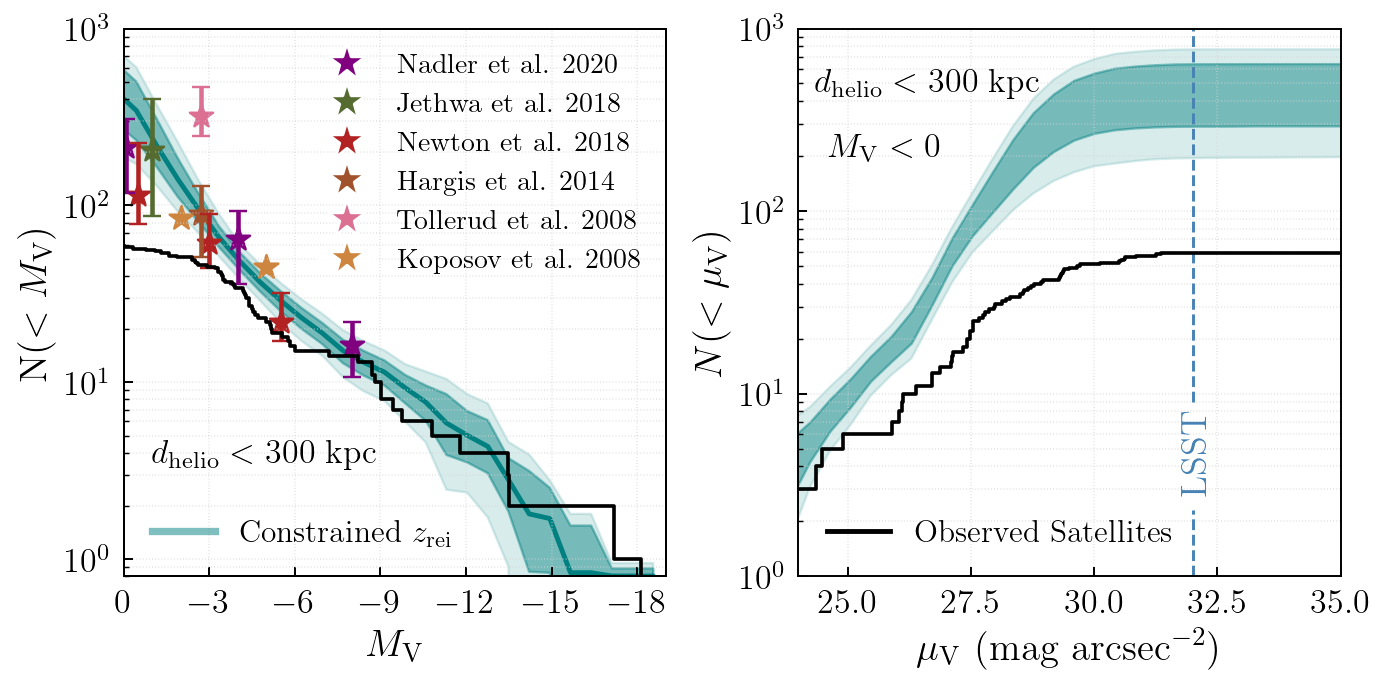

In [88]:
from matplotlib.lines import Line2D

fig,ax = plt.subplots(1,2,figsize = (8,4))
from matplotlib.lines import Line2D


plt.subplots_adjust(wspace = 0.1)


plot_contours(ax=ax[0],xlims_plot = [0,-19],ylims_plot = [0.8,1000],
                    xlabel = True, ylabel = True,grid = True,
                     fsize = 16,mcol = "teal",sig1 = True,sig2 = True,sig3=False,median=True,
                   label = None,med_ls = "-",fsize_leg = 7.5,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log",
                 all_contours=lf_conts)


ax2 = ax[0].twinx()
ax2.get_yaxis().set_visible(False)


legend_elements = [Line2D([0], [0], marker='*', color='w', label=r'\rm Nadler et al. 2020',markerfacecolor='purple', markersize=16),
                   Line2D([0], [0], marker='*', color='w', label=r'\rm Jethwa et al. 2018',markerfacecolor='darkolivegreen', markersize=16), 
                   Line2D([0], [0], marker='*', color='w', label=r'\rm Newton et al. 2018',markerfacecolor='firebrick', markersize=16),
                   Line2D([0], [0], marker='*', color='w', label=r'\rm Hargis et al. 2014',markerfacecolor='sienna', markersize=16),
                   Line2D([0], [0], marker='*', color='w', label=r'\rm Tollerud et al. 2008',markerfacecolor='palevioletred', markersize=16),
                   Line2D([0], [0], marker='*', color='w', label=r'\rm Koposov et al. 2008',markerfacecolor='peru', markersize=16)  
                   ]

#                    Line2D([0], [0], marker='^', color = 'w',label=r'\rm Koposov et al. 2009',fillstyle='left',markerfacecolor = "olivedrab",markerfacecoloralt='none',markeredgecolor = "olivedrab", markersize=9.5),

legend_elements_2 = [Line2D([0], [0], color='teal', lw=3,label=r'\rm Constrained $z_{\rm rei}$',alpha = 0.5)
                   ]


#Koposov 2008. This is mentioned in section 5.2 of the paper
ax[0].scatter([-2],[85],color = "peru",marker = "*",s=105)
ax[0].scatter([-5],[45],color = "peru",marker = "*",s=105)


#Koposov 2009. reproduce these numbers for Mv = -2 ish. These were originally for -1
# p1 = ax.scatter([-1.5],[415],color = "olivedrab",marker = "^",s=55)
# p2 = ax.scatter([-1.5],[110],facecolor = "none",edgecolor = "olivedrab",marker = "^",s=55,lw = 1)

#Tollerud 2008
ax[0].scatter([-2.7],[322],color = "palevioletred",marker = "*",s=100)
ax[0].errorbar([-2.7], [322], yerr=  np.array([[322 - 246, 466 - 322]]).T, capsize=3*1.25, elinewidth=1.5*1.25,color = "palevioletred")


ax[0].scatter([-2.7],[89.5],color = "sienna",marker = "*",s=100)
ax[0].errorbar([-2.7], [89.5], yerr=  np.array([[89.5 - 51,128 - 89.5]]).T, capsize=3*1.25, elinewidth=1.5*1.25,color = "sienna")



###JETHWA 2018
ax[0].scatter([-1], [(235+178)/2],color = "darkolivegreen",marker = "*",s=100)
ax[0].errorbar([-1], [(235+178)/2], yerr=  np.array([[(235+178)/2 - 87, 402 - (235+178)/2 ]]).T, capsize=3*1.25, elinewidth=1.5*1.25,color = "darkolivegreen")


#NADLER 2020
ax[0].errorbar([-0.1], [0.5*(308+117)], yerr=  np.array([[0.5*(308+117) - 117, 308 - 0.5*(308+117)]]).T, capsize=3*1.25, elinewidth=1.5*1.25,color = "purple")
ax[0].errorbar([-4], [0.5*(93+36)], yerr=  np.array([[  0.5*(93+36)   - 36, 93 -  0.5*(93+36)  ]]).T, capsize=3*1.25, elinewidth=1.5*1.25,color = "purple")
ax[0].errorbar([-8], [0.5*(21.8+10.7)], yerr=  np.array([[  0.5*(21.8 + 10.7)  - 10.7 , 21.8 - 0.5*(21.8 + 10.7)    ]]).T, capsize=3*1.25, elinewidth=1.5*1.25,color = "purple")
ax[0].scatter([-0.1], [0.5*(258.67+167.2)],color = "purple",marker = "*",s=100)
ax[0].scatter([-4], [0.5*(78.4+50.3)],color = "purple",marker = "*",s=100)
ax[0].scatter([-8], [0.5*(18.97+13.62)],color = "purple",marker = "*",s=100)

##Newton et 2018 results
ax[0].errorbar([-0.5], [115], yerr=  np.array([[115-78,225-115]]).T, capsize=3*1.25, elinewidth=1.5*1.25,color = "firebrick")
ax[0].errorbar([-3], [61], yerr=  np.array([[61  - 44, 89-61  ]]).T, capsize=3*1.25, elinewidth=1.5*1.25,color = "firebrick")
ax[0].errorbar([-5.5], [22], yerr=  np.array([[ 22 - 17, 32-22    ]]).T, capsize=3*1.25, elinewidth=1.5*1.25,color = "firebrick")
ax[0].scatter([-0.5], [115],color = "firebrick",marker = "*",s=100)
ax[0].scatter([-3], [61],color = "firebrick",marker = "*",s=100)
ax[0].scatter([-5.5], [22],color = "firebrick",marker = "*",s=100)

# ax2.hist(all_mw_mags, cumulative = 1,color = "k",lw = 1.2,histtype = "step",bins = np.sort(all_mw_mags))
ax2.legend(frameon=False, fontsize = 11.5,loc = "upper right",handles = legend_elements)
ax[0].legend(frameon=False, fontsize = 13,loc = "lower left",handles = legend_elements_2)

# ax.legend(frameon=False, fontsize = 11.5,loc = "lower left",handles = legend_elements_1)

ax[0].text(-1,3.5,r"\rm $d_{\rm helio} < 300$ kpc",fontsize = 14, weight="bold")
# ax.text(-12,20,r"\rm Caterpillar",fontsize = 16, weight="bold")

xmw_a, ymw_a = get_linear_hist(all_mw_mags)
ax[0].plot(xmw_a,ymw_a,color = "k",lw = 1.5)

ax[0].set_xticks([0,-3,-6,-9,-12,-15,-18])

ax[0].tick_params(axis = "x",labelsize = 14)
ax[0].tick_params(axis = "y",labelsize = 14)



plot_contours(ax=ax[1],xlims_plot = [24,35],ylims_plot = [1,1000],
                    xlabel = False, ylabel = False,grid = True,
                     fsize = 16,mcol = "teal",sig1 = True,sig2 = True,sig3=False,median=False,
                   label = None,med_ls = "-",fsize_leg = 7.5,xlabel_txt = r'$M_{\rm V}$',med_lw=2,
                   ylabel_txt = r'\rm N$(<M_{\rm V})$',shade=True,noshade_lw = 1,yscale = "log",
                 all_contours=sb_all_conts)


ax[1].set_xlabel(r"\rm $\mu_{\rm V}$ (mag arcsec$^{-2}$)",fontsize = 16)
ax[1].set_ylabel(r"\rm $N( < \mu_{\rm V})$",fontsize = 16)

ax[1].tick_params(axis = "x",labelsize = 14)
ax[1].tick_params(axis = "y",labelsize = 14)

ax[1].vlines(32,ymin = 1,ymax = 2.3,color = "steelblue",ls = "--",lw = 1.2)
ax[1].vlines(32,ymin = 9,ymax = 2000,color = "steelblue",ls = "--",lw = 1.2)

ax[1].text(31.75,3,r"\rm LSST",fontsize = 15,color = "steelblue",rotation = 90,weight = "bold")

ax[1].text(24.35,450,r"\rm $d_{\rm helio} < 300$ kpc",fontsize = 14, weight="bold")
ax[1].text(24.6,200,r"\rm $M_{\rm V} < 0$",fontsize = 14, weight="bold")


# mw_data_mu30 = all_mw_mags[all_surfs_data < 30]
xs_30, ys_30 = get_linear_hist(all_surfs_data,oppo=False,minx = 37)
ax[1].plot(xs_30,ys_30,color = "k",lw = 1.5)

legend_elements_2 = [Line2D([0], [0], color='k', lw=2,ls = "-",label=r'\rm Observed Satellites',alpha = 1),
                      ]

ax[1].legend(frameon=False, fontsize = 13,loc = "lower left",handles = legend_elements_2)


plt.tight_layout()
# plt.savefig("paper_figs_cater_pdf/total_muv_mv_300.pdf")

plt.show()



## B ) Size-luminosity plane

In [204]:
## load the model data (combination of caterpillar, hires elvis, phat elvis, and elvis?)

all_cats = glob.glob(data_path + "/caterpillar_outputs/LX14_outs/LX14_zrei8_5_etan18_etap_045_all_CC/*csv")

all_hires = glob.glob(data_path + "/caterpillar_outputs/elvis/Hires_zrei8_5_etan18_etap_045/*csv")
all_iso = glob.glob(data_path + "/caterpillar_outputs/elvis/old/elvis_iso_zrei9_etan18_etap_045/*csv")
all_phats_dmo = glob.glob(data_path + "/caterpillar_outputs/elvis/pelvis_dmo_zrei8_5_etan18_etap_045_all/*csv")
all_phats_disk = glob.glob(data_path + "/caterpillar_outputs/elvis/pelvis_disk_zrei8_5_etan18_etap_045_all/*csv")

print(len(all_cats),len(all_hires),len(all_phats_dmo),len(all_phats_disk))


32 2 12 12


In [205]:
    
MsLV = 2.0

def muV_lines(ax=None,muV=None,ls = ":",lw = 1,color = "indianred"):
    mvtr = np.linspace(5,-20,100)    
    term1 = (muV -  mvtr - 21.5721)/2.5
    
    rps = np.sqrt(10**term1/(2*np.pi))
    
    ax.plot(np.log10(rps),mvtr,ls = ls, lw = lw,color = color)

    return 


from matplotlib.colors import LogNorm

In [206]:
mvs_all = []
rs_all = []


other_color = "cyan"

for i,si in tqdm(enumerate(all_cats+all_hires+all_phats_dmo+all_phats_disk+all_iso)):
    dfi = pd.read_csv(si)
    rsizes = dfi["rsize"]
    mVs = dfi["mV"]
    hdisti = dfi["hdist"]
    mpeaki = dfi["Mpeak"]
    
    temp_mh = np.array(dfi["Mh"])
    temp_mpeak = np.array(dfi["Mpeak"])
    temp_ratio = temp_mh/temp_mpeak

    mv_f = np.array(mVs[(mVs < 0.5) & (mpeaki > 1e6) & (temp_ratio < 10)& (temp_ratio > 0.1)])
    rs_f = np.array(rsizes[(mVs < 0.5) & (mpeaki > 1e6)& (temp_ratio < 10) & (temp_ratio > 0.1)])*1e3
    mvs_all.append(mv_f)
    rs_all.append(rs_f)

mvs_all = np.concatenate(mvs_all)
rs_all = np.concatenate(rs_all)

print(len(mvs_all))


194753


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


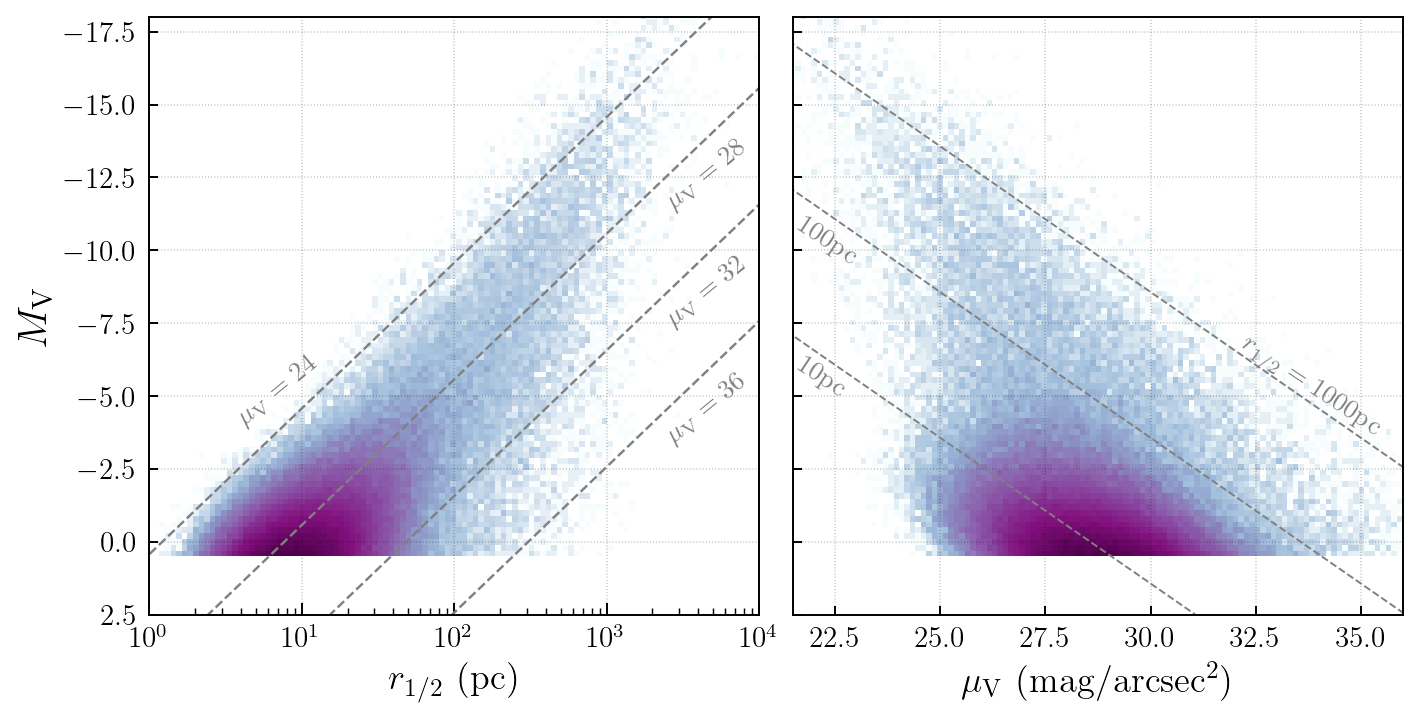

In [207]:


# fig,ax = plt.subplots(1,1,figsize = (4,4),constrained_layout=True)

fig,ax = plt.subplots(1,2,figsize = (8,4),sharey = True,constrained_layout=True)


h = ax[0].hist2d(np.log10(rs_all/1.34),mvs_all,bins=110,norm = LogNorm(),density = True,cmap = "BuPu",zorder = 0)

muV_lines(ax=ax[0],muV = 36,ls = "dashed",lw = 1,color = "grey")
muV_lines(ax=ax[0],muV = 32,ls = "--",lw = 1,color = "grey")
muV_lines(ax=ax[0],muV = 24,ls = "--",lw = 1,color = "grey")
muV_lines(ax=ax[0],muV = 28,ls = "--",lw = 1,color = "grey")

ax[0].text(3.36,-0.74-2.65,r"\rm $\mu_{\rm V} = 36$",fontsize = 11,rotation=39.5,color = "grey")
ax[0].text(3.36,-4.74-2.65,r"\rm $\mu_{\rm V} = 32$",fontsize = 11,rotation=39.5,color = "grey")
ax[0].text(3.36,-8.74-2.65,r"\rm $\mu_{\rm V}= 28$",fontsize = 11,rotation=39.5,color = "grey")
ax[0].text(0.55,-4,r"\rm $\mu_{\rm V} = 24$",fontsize = 11,rotation=39.5,color = "grey")


ax[0].set_xlim([2,4])
ax[0].set_ylim([2,-18])
ax[0].grid(ls = ":",color = "k",alpha = 0.2)
ax[0].set_ylabel(r'$M_{\rm V}$',fontsize = 17) 
ax[0].set_xlabel(r'\rm $r_{\rm 1/2}$ (pc)',fontsize = 15)
ax[0].legend(frameon=False,fontsize = 11,loc ="upper left",handletextpad=0.)

ax[0].set_xticks(np.log10([2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90,200,300,400,500,600,700,800,900,2000,3000,4000,5000,6000,7000,8000,9000]),minor=True)
ax[0].set_xticks([0,1,2,3,4],minor=False)
ax[0].set_xticklabels([r'$10^0$',r'$10^1$',r'$10^2$',r'$10^3$',r'$10^4$'])
ax[0].tick_params(axis = "x",labelsize = 12,length = 5,which = "major")
ax[0].tick_params(axis = "x",labelsize = 12,length = 3,which = "minor")
ax[0].tick_params(axis = "y",labelsize = 12)




muv_all = get_muV(mvs_all,rs_all/1.34)


h_muv = ax[1].hist2d(muv_all,mvs_all,bins=[150,110],norm = LogNorm(),density = True,cmap = "BuPu",zorder = 0)


ax[1].legend(frameon=False,fontsize = 11,loc ="upper right",handletextpad=0.)

r12_lines(ax=ax[1],r12=1000,ls = "--",lw = 0.8,color = "grey")
r12_lines(ax=ax[1],r12=100,ls = "--",lw = 0.8,color = "grey")
r12_lines(ax=ax[1],r12=10,ls = "--",lw = 0.8,color = "grey")

ax[1].text(21.53,-4.95,r"\rm 10pc",fontsize = 11,rotation=-33.5,color = "grey")
# ax[1].text(28.3,1.9,r"\rm 10pc",fontsize = 11,rotation=-33.5,color = "grey")
# ax[1].text(30.3,-0.8,r"\rm 100pc",fontsize = 11,rotation=-33.5,color = "grey")

ax[1].text(21.53,-9.5,r"\rm 100pc",fontsize = 11,rotation=-33.5,color = "grey")
ax[1].text(32,-3.7,r"\rm $r_{1/2} = 1000$pc",fontsize = 11,rotation=-33.5,color = "grey")

ax[1].set_xlim([21.5,36])
ax[1].set_ylim([2.5,-18])

ax[1].grid(ls = ":",color = "k",alpha = 0.2)
ax[1].set_xlabel(r'\rm $\mu_{\rm V}$ (mag/arcsec$^2$)',fontsize = 15)

ax[1].tick_params(axis = "x",labelsize = 12)
ax[1].tick_params(axis = "y",labelsize = 12)
# plt.savefig("paper_figs_new/mv_r12_space_new.png")


plt.show()



In [208]:
from scipy.signal import wiener
h_sm = wiener(h[0].T, mysize=2)
h_sm[h_sm < 1e-6] = 0
# h_sm[h_sm > 5e-2] = 5e-2


h_muv_sm = wiener(h_muv[0].T, mysize=2)
h_muv_sm[h_muv_sm < 1e-6] = 0


/Users/radioactive/opt/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1611: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/Users/radioactive/opt/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1611: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


In [210]:
## note that we do this below to reduce the number of objects in the faint end and thus to help 
## in the visual color balance more. This does not change the qualitative picture of the model predicted
## size-luminosity distribution by much 

mvs_new = []
rs_new = []

mv_bins = np.linspace(-18.5,0.5,45)
N = 14000
# N = 20000

# N = 900


ind = 0
#we loop over each of bin and select a certain number from that range and 
for e in range(len(mv_bins)-1):
    mv_high = mv_bins[e+1]
    mv_low = mv_bins[e]
    mv_f = mvs_all[ (mvs_all > mv_low) & (mvs_all<mv_high) ]
    print(len(mv_f),mv_high,mv_low)
    rs_f = rs_all[ (mvs_all > mv_low) & (mvs_all<mv_high) ]
    
    if mv_low >= -2.5: #this was originally 3
#     if mv_low >= -2: #this was originally 3
        
        #we do the resampling           
#     let us get the bootstrap inds:
        rnd_inds = np.random.randint(len(mv_f), size = N+ind*150)
        mv_ff = mv_f[rnd_inds]
        rs_ff = rs_f[rnd_inds]
        mvs_new.append(mv_ff)
        rs_new.append(rs_ff)
        ind+=1
    
    else:
        mvs_new.append(mv_f)
        mvs_new.append(mv_f)
        
        rs_new.append(rs_f)
        rs_new.append(rs_f)
        
        
        
mvs_new = np.concatenate(mvs_new)
rs_new = np.concatenate(rs_new)

23 -18.068181818181817 -18.5
27 -17.636363636363637 -18.068181818181817
19 -17.204545454545453 -17.636363636363637
29 -16.772727272727273 -17.204545454545453
38 -16.34090909090909 -16.772727272727273
46 -15.90909090909091 -16.34090909090909
50 -15.477272727272727 -15.90909090909091
69 -15.045454545454545 -15.477272727272727
80 -14.613636363636363 -15.045454545454545
108 -14.181818181818182 -14.613636363636363
119 -13.75 -14.181818181818182
119 -13.318181818181818 -13.75
174 -12.886363636363637 -13.318181818181818
162 -12.454545454545453 -12.886363636363637
194 -12.022727272727273 -12.454545454545453
258 -11.59090909090909 -12.022727272727273
236 -11.15909090909091 -11.59090909090909
299 -10.727272727272727 -11.15909090909091
307 -10.295454545454545 -10.727272727272727
332 -9.863636363636363 -10.295454545454545
382 -9.431818181818182 -9.863636363636363
414 -9.0 -9.431818181818182
429 -8.568181818181818 -9.0
498 -8.136363636363637 -8.568181818181818
562 -7.704545454545455 -8.136363636363

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


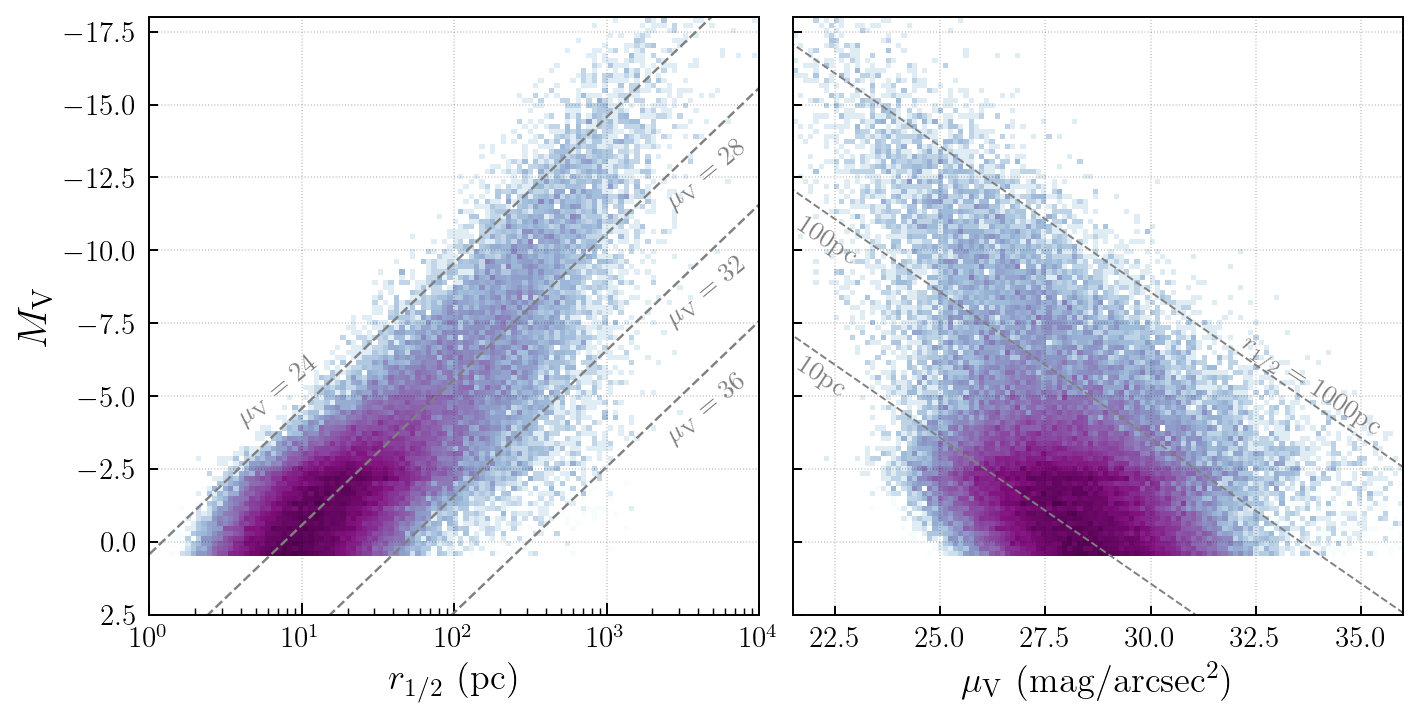

In [211]:
fig,ax = plt.subplots(1,2,figsize = (8,4),sharey = True,constrained_layout=True)


h_mod = ax[0].hist2d(np.log10(rs_new/1.34),mvs_new,bins=110,norm = LogNorm(),density = True,cmap = "BuPu",zorder = 0)

muV_lines(ax=ax[0],muV = 36,ls = "dashed",lw = 1,color = "grey")
muV_lines(ax=ax[0],muV = 32,ls = "--",lw = 1,color = "grey")
muV_lines(ax=ax[0],muV = 24,ls = "--",lw = 1,color = "grey")
muV_lines(ax=ax[0],muV = 28,ls = "--",lw = 1,color = "grey")

ax[0].text(3.36,-0.74-2.65,r"\rm $\mu_{\rm V} = 36$",fontsize = 11,rotation=39.5,color = "grey")
ax[0].text(3.36,-4.74-2.65,r"\rm $\mu_{\rm V} = 32$",fontsize = 11,rotation=39.5,color = "grey")
ax[0].text(3.36,-8.74-2.65,r"\rm $\mu_{\rm V}= 28$",fontsize = 11,rotation=39.5,color = "grey")
ax[0].text(0.55,-4,r"\rm $\mu_{\rm V} = 24$",fontsize = 11,rotation=39.5,color = "grey")


ax[0].set_xlim([2,4])
ax[0].set_ylim([2,-18])
ax[0].grid(ls = ":",color = "k",alpha = 0.2)
ax[0].set_ylabel(r'$M_{\rm V}$',fontsize = 17) 
ax[0].set_xlabel(r'\rm $r_{\rm 1/2}$ (pc)',fontsize = 15)
ax[0].legend(frameon=False,fontsize = 11,loc ="upper left",handletextpad=0.)

ax[0].set_xticks(np.log10([2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90,200,300,400,500,600,700,800,900,2000,3000,4000,5000,6000,7000,8000,9000]),minor=True)
ax[0].set_xticks([0,1,2,3,4],minor=False)
ax[0].set_xticklabels([r'$10^0$',r'$10^1$',r'$10^2$',r'$10^3$',r'$10^4$'])
ax[0].tick_params(axis = "x",labelsize = 12,length = 5,which = "major")
ax[0].tick_params(axis = "x",labelsize = 12,length = 3,which = "minor")
ax[0].tick_params(axis = "y",labelsize = 12)




muv_new = get_muV(mvs_new,rs_new/1.34)


h_muv_mod = ax[1].hist2d(muv_new,mvs_new,bins=[150,110],norm = LogNorm(),density = True,cmap = "BuPu",zorder = 0)


ax[1].legend(frameon=False,fontsize = 11,loc ="upper right",handletextpad=0.)

r12_lines(ax=ax[1],r12=1000,ls = "--",lw = 0.8,color = "grey")
r12_lines(ax=ax[1],r12=100,ls = "--",lw = 0.8,color = "grey")
r12_lines(ax=ax[1],r12=10,ls = "--",lw = 0.8,color = "grey")

ax[1].text(21.53,-4.95,r"\rm 10pc",fontsize = 11,rotation=-33.5,color = "grey")
# ax[1].text(28.3,1.9,r"\rm 10pc",fontsize = 11,rotation=-33.5,color = "grey")
# ax[1].text(30.3,-0.8,r"\rm 100pc",fontsize = 11,rotation=-33.5,color = "grey")

ax[1].text(21.53,-9.5,r"\rm 100pc",fontsize = 11,rotation=-33.5,color = "grey")
ax[1].text(32,-3.7,r"\rm $r_{1/2} = 1000$pc",fontsize = 11,rotation=-33.5,color = "grey")

ax[1].set_xlim([21.5,36])
ax[1].set_ylim([2.5,-18])

ax[1].grid(ls = ":",color = "k",alpha = 0.2)
ax[1].set_xlabel(r'\rm $\mu_{\rm V}$ (mag/arcsec$^2$)',fontsize = 15)

ax[1].tick_params(axis = "x",labelsize = 12)
ax[1].tick_params(axis = "y",labelsize = 12)
# plt.savefig("paper_figs_new/mv_r12_space_new.png")


plt.show()




In [212]:
from scipy.signal import wiener
h_sm_mod = wiener(h_mod[0].T, mysize=3)
h_sm_mod[h_sm_mod < 1e-6] = 0


h_muv_sm_mod = wiener(h_muv_mod[0].T, mysize=3)
h_muv_sm_mod[h_muv_sm_mod < 1e-6] = 0




/Users/radioactive/opt/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1611: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/Users/radioactive/opt/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1611: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)


In [213]:
# ## the satetellites from other surveys 

import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def read_torrealba18(fname):
    f = open(fname, 'r')
    rht = []; Mvt = []
    gname = []
    feh_all = []
    for il, line in enumerate(f):
        if il > 0:
            ld = line.strip()
            cols = ld[17:].split()
            not_cluster = (cols[0] != 'c') and (cols[0] != 'g/c') and (cols[0] != 'c/g') and\
                          (cols[0] != 'c?')
            if  (cols[5] != '-') and (cols[8] != '-') and not_cluster:
                galname = ld[0:16].strip()
                gname.append(galname)
                MV = float(cols[5]); 
                rhpc = float(cols[8]); 
                try:
                    feh = float(cols[9]); 
                except:
                    feh = -99.
                rht.append(rhpc)
                # 4.80 is absolute AB system magnitude of the Sun in V
                # see http://mips.as.arizona.edu/~cnaw/sun.html
                Mvt.append(MV)
                feh_all.append(feh)
                #print dmod, dSun, rh, LV            
    return np.array(gname), np.array(rht), np.array(Mvt),np.array(feh_all)
            

other_data = np.loadtxt("miscel_files/cena_ngc253_data.csv",delimiter =",")

other_rh = other_data[:,0]
other_mv = other_data[:,1]

#let us add hte data from jeff carlin Madcash papers to the arrray


madcash_mv = [-7.81,-9.15]
tucb_mv = [-6.9]

#the papers quote the elliptical half light radius so I should multipy by sqrt(1-eps)
madcash_rh = [178.5*np.sqrt(1 - 0.25), 130.9*np.sqrt(1 - 0.19) ]
tucb_rh = [80]
print(madcash_rh)

other_rh = np.concatenate((other_rh,madcash_rh,tucb_rh))
other_mv = np.concatenate((other_mv,madcash_mv,tucb_mv))


_,other_rh_2,other_mv_2,_ =  read_torrealba18("miscel_files/sats_andro_other.txt")


#####################

mw_sat_data = np.loadtxt("miscel_files/drlica_wagner20_tab2_read.txt",dtype = str)
mw_class = mw_sat_data[:,2].astype(float)
mw_mv = mw_sat_data[:,-2].astype(float)
mw_r12 = mw_sat_data[:,-3].astype(float)
mw_names = mw_sat_data[:,0]

mw_sat_mv = mw_mv[mw_class == 4]
mw_sat_r12 = mw_r12[mw_class == 4]

mw_sat_mv = np.concatenate(([-18.12, -17.18, -13.5],[-9.86,-4.25],mw_sat_mv[4:]))
mw_sat_r12 = np.concatenate(([4735., 2728., 1565.],[2541,41],mw_sat_r12[4:]))


mw_cd_mv = mw_mv[mw_class == 3]
mw_cd_r12 = mw_r12[mw_class == 3]
mv_cd_names = mw_names[mw_class == 3]

mw_cd_mv = np.array( list(mw_cd_mv) + [-4.7] )
mw_cd_r12 = np.array( list(mw_cd_r12) + [75] )

mw_unc_mv = np.array(list([mw_mv[mw_class == 1][0]]) +  [-2.1])
mw_unc_r12 = np.array(list([mw_r12[mw_class == 1][0]]) + [21])
#the -2.1, 21 system is DELVE 2

mw_sc_mv = np.array([-1.2,0,-0.2,-1.4,-1.6,-1.1,0.3,0.3,-1.1, -2.4,-2.1,-5.0,-2.0,-3.3,-0.2,0.3,-3.5,0.7, -1,-0.92, -4.8,-2.8,-0.4,-1.9,0,-1,-1.6,-2.8,-1.81])
mw_sc_r12 = np.array([7.2,4.1,5.4,4.2,6,7.6,1.3,3.9,11.6,8.1,5,9,2.7,7.5,4.3,5.3,12.0,2.1,  6.5,3.4, 19.6,10.8,7.1,4.7,1.8,7.1,3.5,4.8,4.03])


[154.5855345755223, 117.81]


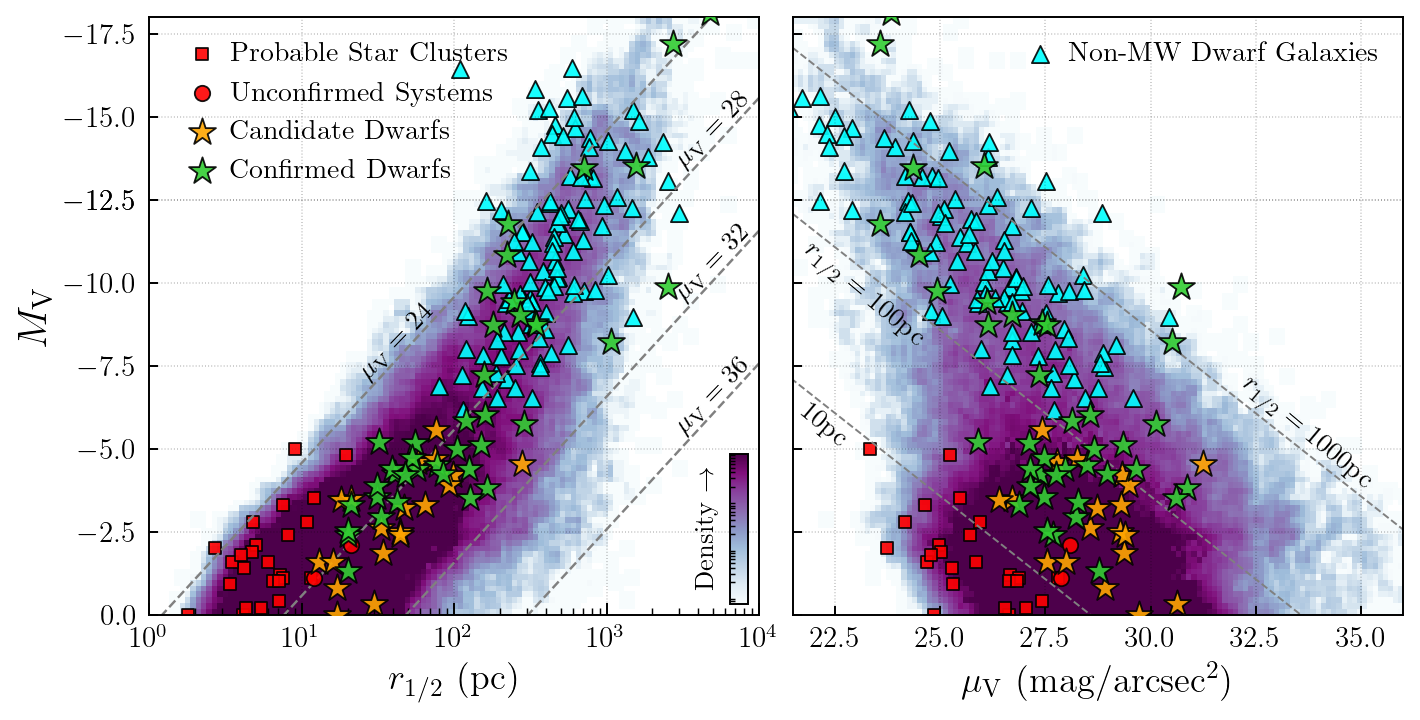

In [215]:

fig,ax = plt.subplots(1,2,figsize = (8,4),sharey = True,constrained_layout=True)


ax[0].imshow(h_sm_mod,norm = LogNorm(vmin = 8e-4,vmax = 3e-2),cmap = "BuPu",extent=(np.min(h_mod[1]),np.max(h_mod[1]),np.min(h_mod[2]),np.max(h_mod[2])),aspect = "auto",origin = "lower")
# ax[0].imshow(h_sm,norm = LogNorm(),cmap = "BuPu",vmin = 2.5*5e-5,vmax = 6e-1,extent=(-0.02690884,3.93984252,-21.51119727,2.49997872),aspect = "auto",origin = "lower")

# colors.PowerNorm(gamma=0.5)

ax[0].scatter(np.log10(mw_sc_r12),mw_sc_mv,facecolor = "red",edgecolor = "k",marker = "s",s=25,lw = 0.75,
          label = r"\rm Probable Star Clusters",alpha = 0.9,zorder = 2)


ax[0].scatter(np.log10(mw_unc_r12),mw_unc_mv,facecolor = "red",edgecolor = "k",marker = "o",s=40,lw = 0.75,
          label = r"\rm Unconfirmed Systems",alpha = 0.9,zorder = 3)


##this is the new dwarf from Eri IV
# ax[0].scatter([np.log10(75)],[-4.7],facecolor = "orange",edgecolor = "k",marker = "*",s=135,lw = 0.75,alpha = 0.9   )


ax[0].scatter(np.log10(mw_cd_r12),mw_cd_mv,facecolor = "orange",edgecolor = "k",marker = "*",s=135,lw = 0.75,
          label = r"\rm Candidate Dwarfs",alpha = 0.9,zorder = 4)

ax[0].scatter(np.log10(mw_sat_r12),mw_sat_mv,facecolor = "limegreen",edgecolor = "k",marker = "*",s=135,lw = 0.75,
          label = r"\rm Confirmed Dwarfs",alpha = 0.9,zorder = 5)


ax[0].scatter(np.log10(other_rh_2),other_mv_2,marker = "^",facecolor =other_color,edgecolor = "k",s=50,lw = 0.75,alpha = 0.9,zorder = 1)
ax[0].scatter(np.log10(other_rh),other_mv,marker = "^",facecolor =other_color,edgecolor = "k",s=50,lw = 0.75,alpha = 0.9,zorder = 1)

# ax[0].scatter(np.log10(harris_r12),harris_mv,marker = "x",color = "k",s =20,lw = 0.5)




muV_lines(ax=ax[0],muV = 36,ls = "dashed",lw = 1,color = "grey")
muV_lines(ax=ax[0],muV = 32,ls = "--",lw = 1,color = "grey")
muV_lines(ax=ax[0],muV = 24,ls = "--",lw = 1,color = "grey")
muV_lines(ax=ax[0],muV = 28,ls = "--",lw = 1,color = "grey")


ax[0].text(3.36+0.065,-0.74-2.65-2-0.075,r"\rm $\mu_{\rm V} = 36$",fontsize = 11,rotation=46,color = "k")
ax[0].text(3.36+0.065,-4.74-2.65-2-0.075,r"\rm $\mu_{\rm V} = 32$",fontsize = 11,rotation=46,color = "k")
ax[0].text(3.36+0.065,-8.74-2.65-2-0.075,r"\rm $\mu_{\rm V}= 28$",fontsize = 11,rotation=46,color = "k")
ax[0].text(1.35,-4-3-0.075,r"\rm $\mu_{\rm V} = 24$",fontsize = 11,rotation=46,color = "k")


ax[0].set_xlim([0,4])
ax[0].set_ylim([0,-18])
ax[0].grid(ls = ":",color = "k",alpha = 0.2)
ax[0].set_ylabel(r'$M_{\rm V}$',fontsize = 17) 
ax[0].set_xlabel(r'\rm $r_{\rm 1/2}$ (pc)',fontsize = 15)
ax[0].legend(frameon=False,fontsize = 11.5,loc ="upper left",handletextpad=0.)
# ax.text(0.4,-15, r"\rm KD (2012)",fontsize = 16,color = "k",weight = "bold")


ax[0].set_xticks(np.log10([2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90,200,300,400,500,600,700,800,900,2000,3000,4000,5000,6000,7000,8000,9000]),minor=True)
ax[0].set_xticks([0,1,2,3,4],minor=False)
ax[0].set_xticklabels([r'$10^0$',r'$10^1$',r'$10^2$',r'$10^3$',r'$10^4$'])
ax[0].tick_params(axis = "x",labelsize = 12,length = 5,which = "major")
ax[0].tick_params(axis = "x",labelsize = 12,length = 3,which = "minor")
ax[0].tick_params(axis = "y",labelsize = 12)

#set log minor ticks


muv_all = get_muV(mvs_all,rs_all/1.34)

muv_mw = get_muV(mw_sat_mv, mw_sat_r12)
muv_sc = get_muV(mw_sc_mv, mw_sc_r12)
muv_cd = get_muV(mw_cd_mv, mw_cd_r12)
muv_unc = get_muV(mw_unc_mv, mw_unc_r12)

muv_other = get_muV(other_mv, other_rh)
muv_other_2 = get_muV(other_mv_2, other_rh_2)


# ax[1].hist2d(muv_all,mvs_all,bins=[190,110],norm = LogNorm(),density = True,cmap = "magma",zorder = 0)
ax[1].imshow(h_muv_sm_mod,norm = LogNorm(vmin = 2e-4,vmax = 1e-2),cmap = "BuPu",extent=(np.min(h_muv_mod[1]),np.max(h_muv_mod[1]),np.min(h_muv_mod[2]),np.max(h_muv_mod[2])),aspect = "auto",origin = "lower")


ax[1].scatter(muv_unc,mw_unc_mv,facecolor = "red",edgecolor = "k",marker = "o",s=40,lw = 0.75,alpha = 0.9,zorder = 3)

ax[1].scatter(muv_sc,mw_sc_mv,facecolor = "red",edgecolor = "k",marker = "s",s=25,lw = 0.75,alpha = 0.9,zorder = 2)

ax[1].scatter(muv_cd,mw_cd_mv,facecolor = "orange",edgecolor = "k",marker = "*",s=135,lw = 0.75,alpha = 0.9,zorder =4)

ax[1].scatter(muv_mw,mw_sat_mv,facecolor = "limegreen",edgecolor = "k",marker = "*",s=135,lw = 0.75,alpha = 0.9,zorder = 5)

ax[1].scatter(muv_other,other_mv,marker = "^",facecolor =other_color,edgecolor = "k",s=50,lw = 0.75,alpha = 0.9,zorder = 1,label = r"\rm Non-MW Dwarf Galaxies")
ax[1].scatter(muv_other_2,other_mv_2,marker = "^",facecolor =other_color,edgecolor = "k",s=50,lw = 0.75,alpha = 0.9,zorder = 1)



ax[1].legend(frameon=False,fontsize = 11.5,loc ="upper right",handletextpad=0.)

r12_lines(ax=ax[1],r12=1000,ls = "--",lw = 0.8,color = "grey")
r12_lines(ax=ax[1],r12=100,ls = "--",lw = 0.8,color = "grey")
r12_lines(ax=ax[1],r12=10,ls = "--",lw = 0.8,color = "grey")

ax[1].text(21.6,-4.95-0.1,r"\rm 10pc",fontsize = 11,rotation=-40,color = "k")
ax[1].text(21.6,-8-0.15,r"\rm $r_{1/2} = 100$pc",fontsize = 11,rotation=-40,color = "k")
ax[1].text(32,-3.7-0.15,r"\rm $r_{1/2} = 1000$pc",fontsize = 11,rotation=-40,color = "k")

ax[1].set_xlim([21.5,36])
ax[1].set_ylim([0,-18])
ax[1].set_yticks([0,-2.5,-5,-7.5,-10,-12.5,-12.5,-15,-17.5])

ax[1].grid(ls = ":",color = "k",alpha = 0.2)
ax[1].set_xlabel(r'\rm $\mu_{\rm V}$ (mag/arcsec$^2$)',fontsize = 15)

ax[1].tick_params(axis = "x",labelsize = 12)
ax[1].tick_params(axis = "y",labelsize = 12)
# plt.savefig("paper_figs_new/mv_r12_space_new.png")


# ####COLOBAR POSITION
# cb_ax = fig.add_axes([1, 1, 0.02, 0.8])
# cbar = fig.colorbar(h[3],ax=ax,location = "bottom",shrink = 0.8)
# cbar.set_label(r"\rm Density",fontsize = 13)
# cbar.ax.tick_params(labelsize=11)
# #################
# ##########

cbaxes = inset_axes(ax[0], width="3%", height="25%",loc = "lower right") 
cbar = fig.colorbar(h[3],cax=cbaxes,ticks=[0.,1],  orientation='vertical')
cbar.set_label(r"\rm Density $\rightarrow$",fontsize = 11,labelpad = 0)

cbar.ax.yaxis.set_ticks_position('left')
cbar.ax.yaxis.set_ticks([])

cbar.ax.yaxis.set_label_position('left')

plt.savefig("mv_r12_space_new.pdf")
# 
plt.show()


##########################################
##########################################
##########################################
##########################################
##########################################
##########################################








## C)  Halo Occupation Fraction

In [171]:
def get_flh(dfs=None,Mhg=None, mVlim=0,parent=False):
    '''
    This is the function to get the halo occupation fraction
    '''
    
    Mhpm = []
    mVm = []
    
    
    for dfi in dfs:
        mpi = np.array(dfi["Mpeak"])
        mvi = np.array(dfi["mV"])
        r12 = np.array(dfi["rsize"])*1e3/1.34
        
        if parent == True:
            pi = np.array(dfi["parent"])
            Mhpm.append(mpi[pi == 1])
            mVm.append(mvi[pi == 1])
        else:
            hdist = np.array(dfi["hdist"])
            Mhpm.append(mpi[(hdist < 300 ) & (hdist > 0) & (r12 > 0)])
            mVm.append(mvi[(hdist < 300 ) & (hdist > 0) & (r12 > 0)])
            
            
        
    Mhpm = np.concatenate(Mhpm)
    mVm = np.concatenate(mVm)
    
    
    flh = []
    for i, md in enumerate(Mhg[1:]): 
        isel1 = ((Mhpm < md) & (Mhpm >Mhg[i]))
        isel2 = ((Mhpm < md) & (Mhpm >Mhg[i]) & (mVm < mVlim))
        fl = np.size(Mhpm[isel2]) / np.maximum(1, np.size(Mhpm[isel1]))
        flh.append(fl)
    return np.array(flh)



def get_flh_diff(dfs=None,Mhg=None, mslim=0,parent=False):
    '''
    This is the function to get the halo occupation fraction
    '''
    
    Mhpm = []
    msm = []
    
    
    for dfi in dfs:
        mpi = np.array(dfi["Mpeak"])
        try:
            msi = np.array(dfi["Msf"])
        except:
            msi = np.array(dfi["Ms"])
            
        r12 = np.array(dfi["rsize"])*1e3/1.34
        
        if parent == True:
            pi = np.array(dfi["parent"])
            Mhpm.append(mpi[pi == 1])
            msm.append(msi[pi == 1])
        else:
            hdist = np.array(dfi["hdist"])
            Mhpm.append(mpi[(hdist < 300 ) & (hdist > 0) & (r12 > 0)])
            msm.append(msi[(hdist < 300 ) & (hdist > 0) & (r12 > 0)])
            
            
        
    Mhpm = np.concatenate(Mhpm)
    msm = np.concatenate(msm)
    
    
    flh = []
    for i, md in enumerate(Mhg[1:]): 
        isel1 = ((Mhpm < md) & (Mhpm >Mhg[i]))
        isel2 = ((Mhpm < md) & (Mhpm >Mhg[i]) & (msm > mslim))
        fl = np.size(Mhpm[isel2]) / np.maximum(1, np.size(Mhpm[isel1]))
        flh.append(fl)
    return np.array(flh)

In [172]:

def read_all_nolmc(path):
    print("-"*15)
    df_list = []
    df_names = []
    all_csv_files = glob.glob(path + "/*.csv")
    for fi in all_csv_files:
            df_list.append(pd.read_csv(fi))
            df_names.append(fi)
                
    if len(df_list) == 0:
        print("None found here " + path)
        
    print(len(df_list))
    print("-"*15)
        
    return df_list



cat_noreion = read_all_nolmc(data_path + "/caterpillar_outputs/LX14_outs/LX14_noreion_etan18_etap_045_nolmc_CC")
cat_z7_nolmc = read_all_nolmc(data_path + "/caterpillar_outputs/LX14_outs/LX14_zrei7_etan18_etap_045_nolmc_CC")
cat_z7_5_nolmc = read_all_nolmc(data_path + "/caterpillar_outputs/LX14_outs/LX14_zrei7_5_etan18_etap_045_nolmc_CC")
cat_z8_5_nolmc = read_all_nolmc(data_path + "/caterpillar_outputs/LX14_outs/LX14_zrei8_5_etan18_etap_045_nolmc_CC")


cat_z9_5_nolmc = read_all_nolmc(data_path + "/caterpillar_outputs/LX14_outs/LX14_zrei9_5_etan18_etap_045_nolmc_CC")
cat_z10_5_nolmc = read_all_nolmc(data_path + "/caterpillar_outputs/LX14_outs/LX14_zrei10_5_etan18_etap_045_nolmc_CC")

cat_z8_5_all = read_all_nolmc(data_path + "/caterpillar_outputs/LX14_outs/LX14_zrei8_5_etan18_etap_045_all_CC")




---------------
6
---------------
---------------
16
---------------
---------------
16
---------------
---------------
30
---------------
---------------
16
---------------
---------------
16
---------------
---------------
32
---------------


In [173]:
##GET ALL THE DATA


lMhg = np.linspace(6, 10, 25)
Mhg = 10.**lMhg

flh_noreion = get_flh(dfs = cat_noreion,Mhg=Mhg, mVlim=0)
flh_z8_5 = get_flh(dfs=cat_z8_5_all ,Mhg=Mhg, mVlim=0)

flh_z10_5 = get_flh(dfs=cat_z10_5+cat_z10_5_nolmc,Mhg=Mhg, mVlim=0)
flh_z9_5 = get_flh(dfs=cat_z9_5+cat_z9_5_nolmc,Mhg=Mhg, mVlim=0)
flh_z7_5 = get_flh(dfs=cat_z7_5+cat_z7_5_nolmc,Mhg=Mhg, mVlim=0)
flh_z7 = get_flh(dfs=cat_z7+cat_z7_nolmc,Mhg=Mhg, mVlim=0)


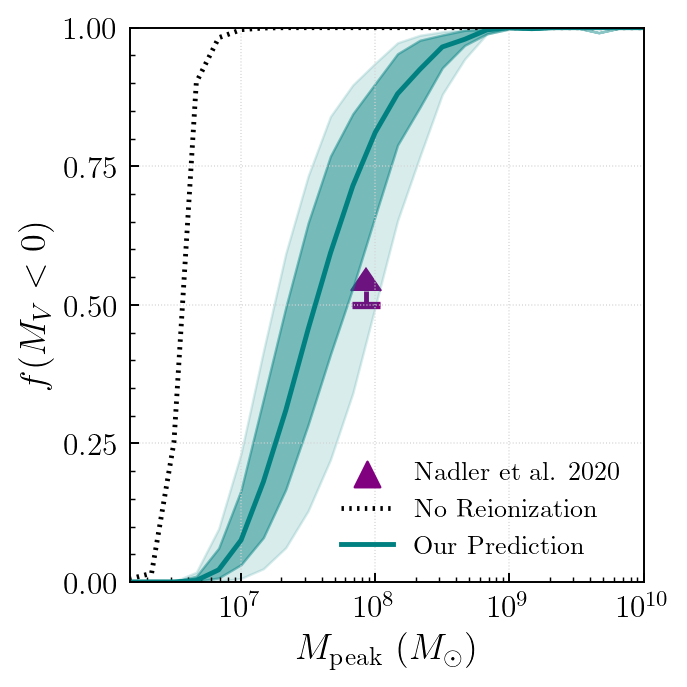

In [174]:
fig, ax = plt.subplots(1,1, figsize=(4, 4))
m200n = 8.5e7 # M200c for Nadler et al.
fn = 0.5
ax.errorbar(m200n, fn, yerr=0.025, lolims=True, ls=None, 
             marker='_', markersize=40, capsize=6, ecolor='purple', 
             mew=1., lw=2, c='white', zorder=0)

ax.scatter(m200n, fn, marker='_', s=130, lw=3, c='purple')
ax.scatter(0, 1, marker='^', s=110, lw=1, c='purple', label=r'\rm Nadler et al. 2020')
ax.plot( Mhg[1:],flh_noreion,lw = 2,color = "k",ls = "dotted",label = r"\rm No Reionization")
ax.plot(Mhg[1:], flh_z8_5, c='teal', lw=2, ls='-',label = r"\rm Our Prediction")

ax.fill_between(Mhg[1:],flh_z7_5,flh_z9_5,color = "teal",alpha = 0.45)
ax.fill_between(Mhg[1:],flh_z7,flh_z10_5,color = "teal",alpha = 0.15)
ax.tick_params(axis = "x",labelsize = 13)
ax.tick_params(axis = "y",labelsize = 13)

mp_ttr = np.linspace(6,10)
# ax.plot(10**mp_ttr,halo_occ_mod(mp_ttr),color = "k")

ax.legend(frameon=False, loc='lower right', fontsize=10.9)

ax.grid(linestyle=':', c='lightgray',alpha =0.7)

ax.legend(frameon=False, loc='lower right', fontsize=10.75)

ax.set_ylabel(r'\rm $f(M_V<0)$',fontsize = 15)
ax.set_xlabel(r'\rm $M_{\rm peak}\ (M_\odot)$',fontsize = 15)
ax.set_xscale('log')
ax.set_xlim(1.5e6, 1e10); 
ax.set_ylim(0., 1)
ax.xaxis.set_ticks([1e7, 1e8, 1e9, 1e10])
ax.yaxis.set_ticks([0, 0.25, 0.5, 0.75, 1.0])
ax.minorticks_on()
plt.tight_layout()
# plt.savefig("paper_figs_cater_pdf/halo_occ_frac.pdf")
plt.show()





## D) Stellar Mass Halo Mass relation

In [229]:

cat_z7_nolmc = read_all_nolmc(data_path + "/caterpillar_outputs/LX14_outs/LX14_zrei7_etan18_etap_045_nolmc_CC")
cat_z7_5_nolmc = read_all_nolmc(data_path + "/caterpillar_outputs/LX14_outs/LX14_zrei7_5_etan18_etap_045_nolmc_CC")
cat_z8_5_nolmc = read_all_nolmc(data_path + "/caterpillar_outputs/LX14_outs/LX14_zrei8_5_etan18_etap_045_nolmc_CC")


cat_z9_5_nolmc = read_all_nolmc(data_path + "/caterpillar_outputs/LX14_outs/LX14_zrei9_5_etan18_etap_045_nolmc_CC")
cat_z10_5_nolmc = read_all_nolmc(data_path + "/caterpillar_outputs/LX14_outs/LX14_zrei10_5_etan18_etap_045_nolmc_CC")


all_total_dfs_nolmc = 7*(cat_z8_5+cat_z8_5_nolmc) + 4*(cat_z7_5+cat_z7_5_nolmc) + 1*(cat_z7+cat_z7_nolmc) + 4*(cat_z9_5+cat_z9_5_nolmc) + 1*(cat_z10_5+cat_z10_5_nolmc) 


---------------
16
---------------
---------------
16
---------------
---------------
30
---------------
---------------
16
---------------
---------------
16
---------------


In [231]:

def get_shmr(all_dfs):
    
    all_mpeak = []
    all_mstar = []

    for i,dfi in enumerate(all_dfs):
        mpeak = np.array(dfi['Mpeak'])
        ms = np.array(dfi['Ms'])

        msf = ms[ms > 1]
        mpeakf = mpeak[ms > 1]

        all_mpeak.append(mpeakf)
        all_mstar.append(msf)


    all_mpeak = np.concatenate(all_mpeak)
    all_mstar = np.concatenate(all_mstar)
    
    
    return all_mpeak, all_mstar



def B13_modified(lmvir,lM1 = 11.39,leps = -1.385, alfa = -1.6,delta = 4.335,gamma = 0.531):    
    
    lMsK18_new_p1 = MsMh_B13form(lmvir, lM1, leps, alfa, delta, gamma)
    
    x = 10**lmvir
    
    y = (10**lMsK18_new_p1 / (1 + (x/1e10)**(-1.3))) + 5e2*(x/1e8)**0.9
    
    return y


n20_shmr =np.loadtxt('miscel_files/nadler_etal_fig6_1sig.dat')

mp_all,ms_all = get_shmr(all_total_dfs_nolmc)

mp_bins, ms_md, ms_23,ms_977, ms_159, ms_841, ms_002,ms_998 = get_shade(np.log10(mp_all),np.log10(ms_all),np.linspace(6.5,11.3,16)   ) 




In [232]:
def fB13(x, alfa, delta, gamma):
    dummy = -np.log10(10.**(alfa*x)+1.) + delta*(np.log10(np.exp(x)+1.))**gamma/(1.+np.exp(10.**(-x)))
    return dummy



def MsMh_B13form(lMvir, lM1, leps=11.39, alfa=-2, delta=4.335, gamma=0.531):
    lMsB13 = leps + lM1 + fB13(lMvir-lM1,alfa, delta, gamma) - fB13(0.,alfa, delta, gamma)
    return lMsB13


#the below relation is for star forming halos only. 

xlog = np.linspace(6,13,100)
x_shmr = 10**xlog
y_shmr = B13_modified(xlog)



/Users/radioactive/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


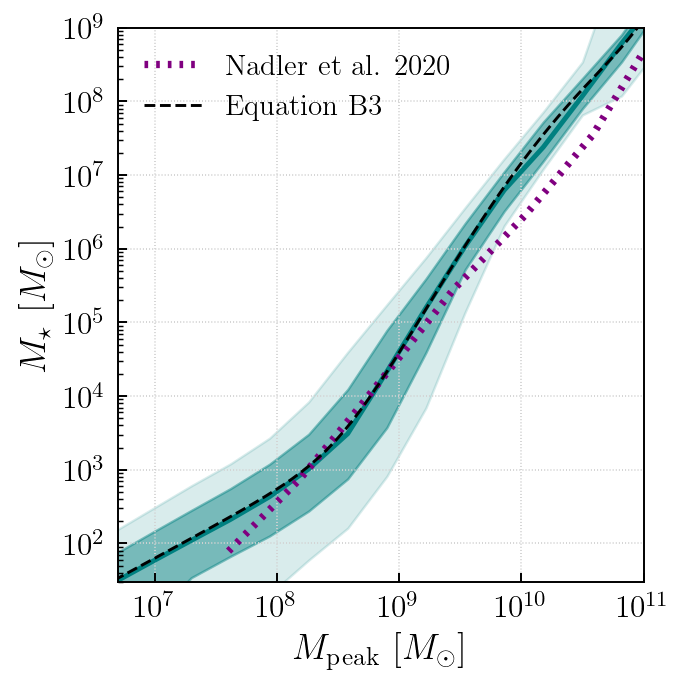

In [233]:
import matplotlib.ticker

fig,ax = plt.subplots(1,1,figsize = (4,4))

t_col = "teal"
b13_mod = 10**(mp_bins[:-1])

ax.fill_between(10**mp_bins, 10**ms_159, 10**ms_841,color = t_col,alpha = 0.45)
ax.fill_between(10**mp_bins, 10**ms_23, 10**ms_977,color = t_col,alpha = 0.15)
ax.plot(10**mp_bins,10**ms_md,color = t_col,lw=2)

# ax.plot(10**mp_bins_mod,10**ms_md_mod,color = "hotpink",lw=2,label = r"\rm The Full Parametrization")

ax.plot(10**n20_shmr[:,0],10**(0.5*(n20_shmr[:,2]+n20_shmr[:,1])),color = "purple",ls="dotted",lw=3,label = r"\rm Nadler et al. 2020")
# ax.plot(x_med_j18,y_med_j18,color = "purple",ls="dotted",lw=2.5,label = r"\rm Jethwa et al. 2018")


# ax.plot(10**mp_bins_mod,10**ms_md_mod, color ='k', lw=1.2, label=r"\rm Equation B6",ls = "--")
ax.plot(x_shmr,y_shmr, color ='k', lw=1.2, label=r"\rm Equation B3",ls = "--")



ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"\rm $M_{\rm peak}$ $[M_{\odot}]$",fontsize = 15)
ax.set_ylabel(r"\rm $M_{\star}$ $ [M_{\odot}]$",fontsize = 15)
ax.set_xlim([5e6,1e11])
ax.set_ylim([30,1e9])
ax.set_yticks([1e2,1e3,1e4,1e5,1e6,1e7,1e8,1e9])
ax.set_xticks([1e7,1e8,1e9,1e10,1e11])

ax.grid(ls = ":",color = "lightgrey")


y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
ax.yaxis.set_minor_locator(y_minor)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())



ax.tick_params(axis = "x",labelsize = 13)
ax.tick_params(axis = "y",labelsize = 13)

ax.legend(frameon=False,loc = "upper left",fontsize = 12)


plt.tight_layout()


plt.show()



In [ ]:
import matplotlib.ticker

fig,ax = plt.subplots(1,1,figsize = (4,4))



t_col = "teal"
# b13_mod = 10**(mp_bins[:-1])

ax.fill_between(10**mp_bins, 10**ms_23, 10**ms_977,color = t_col,alpha = 0.15,zorder = 0)
ax.fill_between(10**mp_bins, 10**ms_159, 10**ms_841,color = t_col,alpha = 0.45,zorder = 0)
ax.plot(10**mp_bins,10**ms_md,color = t_col,lw=2,zorder = 0,label = r"\rm GRUMPY")

# ax.plot(10**mp_bins_mod,10**ms_md_mod,color = "hotpink",lw=2,label = r"\rm The Full Parametrization")

# ax.plot(10**n20_shmr[:,0],10**(0.5*(n20_shmr[:,2]+n20_shmr[:,1])),color = "purple",ls="dotted",lw=3,label = r"\rm Nadler et al. 2020")
# ax.plot(x_med_j18,y_med_j18,color = "purple",ls="dotted",lw=2.5,label = r"\rm Jethwa et al. 2018")


# ax.plot(10**mp_bins_mod,10**ms_md_mod, color ='k', lw=1.2, label=r"\rm Equation B6",ls = "--")
# ax.plot(x_shmr,y_shmr, color ='k', lw=1.2, label=r"\rm Equation B3",ls = "--")

sdf = pd.read_csv("miscel_files/santisevan_etal22_ms_mh.csv")
mhb = sdf['Halo mass']

#'Median Mstar (Msun)',
#       'Lower 68th percentile (Msun)', 'Upper 68th percentile (Msun)',
#       'Lower 100th percentile (Msun)', 'Upper 100th percentile (Msun)'

ax.plot(sdf['Halo mass'], sdf['Median Mstar (Msun)'], lw=1.5, c='lightgreen', label=r'$\rm Santistevan+\ 22$')
ax.plot(sdf['Halo mass'], sdf['Lower 68th percentile (Msun)'], c='lightgreen', lw=1.75, ls=':')
ax.plot(sdf['Halo mass'], sdf['Upper 68th percentile (Msun)'], c='lightgreen', lw=1.75, ls=':')
#ax.plot(sdf['Halo mass'], sdf['Lower 100th percentile (Msun)'], c='lightskyblue', lw=0.5, ls=':')
#ax.plot(sdf['Halo mass'], sdf['Upper 100th percentile (Msun)'], c='lightskyblue', lw=0.5, ls=':')



mhpeaka, msa = np.loadtxt('miscel_files/applebaum_etal21_tab2.txt', usecols=(3,4), unpack=True)
ax.scatter(mhpeaka, msa, marker='*',facecolor='limegreen',edgecolor="k",s=75,lw=0.5,label=r'$\rm Applebaum+\ 21$')

ax.scatter(mhg, msg, marker='D', c='forestgreen',edgecolor= "k",lw = 0.5,s=35,label=r'$\rm Gutcke+\ 22$')

mho, mso, mvo = np.loadtxt('miscel_files/orkney21_tab1.dat', usecols=(1,3,5), unpack=True)
ax.scatter(mho, mso, marker='^', facecolor='lime',edgecolor ="k",s=55,lw=0.5, label=r'$\rm Orkney+\ 21$')

mhg, lmsmh = np.loadtxt('miscel_files/gutcke_etal22_tab2', usecols=(1,2), unpack=True)

msg = 10**lmsmh * mhg



ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"\rm $M_{\rm peak}$ $[M_{\odot}]$",fontsize = 15)
ax.set_ylabel(r"\rm $M_{\star}$ $ [M_{\odot}]$",fontsize = 15)
ax.set_xlim([4e7,1e11])
ax.set_ylim([1e3,1e9])
ax.set_yticks([1e3,1e4,1e5,1e6,1e7,1e8,1e9])
ax.set_xticks([1e8,1e9,1e10,1e11])
ax.grid(ls = ":",color = "lightgrey")
y_minor = matplotlib.ticker.LogLocator(base = 10.0, subs = np.arange(1.0, 10.0) * 0.1, numticks = 10)
ax.yaxis.set_minor_locator(y_minor)
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.tick_params(axis = "x",labelsize = 13)
ax.tick_params(axis = "y",labelsize = 13)

ax.legend(frameon=False,loc = "upper left",fontsize = 10)

plt.tight_layout()
plt.savefig('mhms_wk22_sims.pdf', bbox_inches='tight')
plt.show()



## E) Mass metallicity relationship

In [235]:
def get_Z_star(dfs,f = False):

    all_mv = []
    all_zs = []

    for dfi in dfs:
        Zsun = 0.015
        MZs = np.array(dfi["MZs"])
        Ms = np.array(dfi["Ms"])
        mv = np.array(dfi["mV"])
        for i,mvi in enumerate(mv):
            if Ms[i] > 0 and MZs[i] > 0:
                all_mv.append(mvi)
                all_zs.append(np.log10(MZs[i]/Ms[i]/Zsun))
  
    return all_mv, all_zs

In [236]:
all_mv,all_zs = get_Z_star(cat_z8_5_all)
mv_bins, f_md, f_23,f_977, f_159, f_841, f_002,f_998 = get_shade(all_mv,all_zs,np.linspace(-15,1,15)   )

In [237]:
### DATA FROM SIMON 2019 paper 

#this is page 1 of table 1
mw_sats_feh_1 = [-1.73, -2.14, -2.52, -1.07, -2.76, -2.65, -2.38, -1.80, -2.44, -2.23, -1.91, -2.71]
upp_err_1 = [0.03,0.16,0.09,0.02,0.10,0.07,0.13,0.02,0.09,0.21,0.12,0.45]
low_err_1 = [0.02,0.15,0.09,0.01,0.10,0.07,0.13,0.02,0.09,0.24,0.14,0.39]
mv_1 = [-10.82,-1.98,-4.71,-13.34,-3.76,-3.99,-7.10,-9.45,-4.50,-4.43,-8,-1.30 ]
mv_herr_1 = [0.14,0.88,0.08,0.14,0.56,0.38,0.30,0.05,0.10,0.26,0,0.73]
mv_lerr_1 = [0.14,0.88,0.08,0.14,0.56,0.38,0.30,0.05,0.10,0.26,0,0.73]


#this page 2 of table 1
mw_sats_feh_2 = [-1.48, -1.97, -2.16, -1.68, -2.48, -2.29, -1.98, -2.43, -2.35, -1.91, -2.79, -2.35, -2.12, -2.47, -2.00] #, -0.53]
upp_err_2 = [0.02,0.04,0.11,0.02,0.21,0.19,0.10,0.11,0.16,0.04,0.06,0.09,0.03,.13,0.02] #,0.03]
low_err_2 = [0.01,0.04,0.13,0.03,0.21,0.22,0.10,0.11,0.19,0.04,0.10,0.08,0.02,0.12,0.02] #,0.02]
mv_2 = [-11.78,-8.94,-5.13,-9.74,-4.29,-4.99,-8.20,-4.28,-5.17,-8.73,-2.94,-6.02,-9.03,-5.83,-8.88] #,-13.50 ]
mv_herr_2 = [0.28,0.06,0.38,0.04,0.36,0.26,0.10,0.25,0.32, 0.06, 0.74, 0.25,0.05,0.17,0.05] #,0.15]
mv_lerr_2 = [0.28,0.06,0.38,0.04,0.36,0.26,0.10,0.25,0.32, 0.06, 0.74, 0.25,0.05,0.17,0.05] #,0.15] 

#thi is page 3 of table 1

mw_sats_feh_3 = [-2.40, -2.30, -2.90, -2.45] # -2.42]
upp_err_3 = [0.15,0.50,0.15,0.07] #,0.07]
low_err_3 = [0.15,0.50,0.16,0.07] #,0.08]
mv_3 = [-4.10,-4.36, -3.90, -4.23] #, -1.49]
mv_herr_3 = [0.50,0.14,0.20,  0.38] #,0.20]
mv_lerr_3 = [0.50,0.14,0.20,  0.38] #,0.20]


#values from antlia and crater from Ji et al. 2021
mw_sats_feh = mw_sats_feh_1+mw_sats_feh_2+mw_sats_feh_3 + [-1.90,-2.16]
feh_upp_err = np.array(upp_err_1+upp_err_2+upp_err_3 + [0.04,0.04] )
feh_low_err = np.array(low_err_1+low_err_2+low_err_3 + [0.04,0.04])

mv_sats = mv_1 + mv_2 + mv_3 +  [-9.86, -8.2]

mv_herr = np.array(mv_herr_1 + mv_herr_2 + mv_herr_3+ [0.08,0] ) 
mv_lerr = np.array(mv_lerr_1 + mv_lerr_2 + mv_lerr_3+ [0.08,0]) 


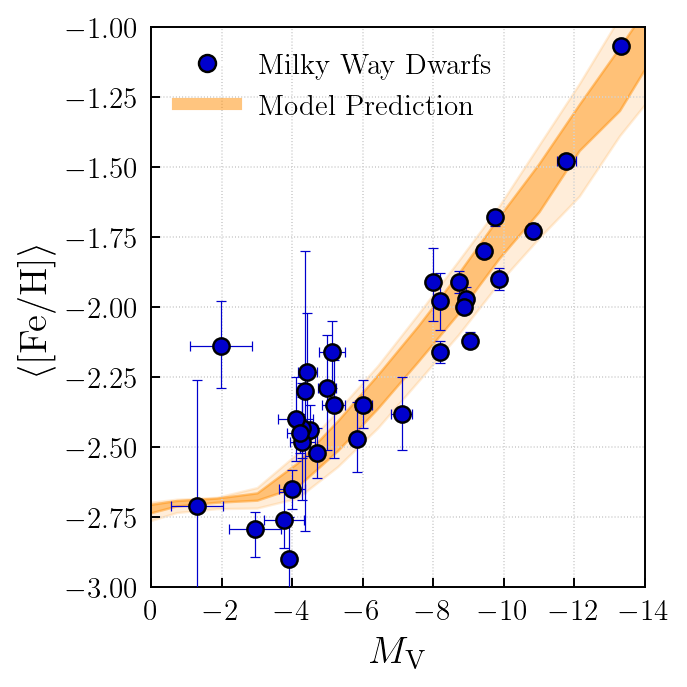

In [238]:

fig,ax = plt.subplots(1,1,figsize = (4,4))



legend_elements = [Line2D([0], [0], marker='o', color='w', label=r"\rm Milky Way Dwarfs",markerfacecolor='mediumblue',markeredgecolor = 'k', markersize=7),
                   Line2D([0], [0], color='darkorange', lw=5,ls = "-",label=r'\rm Model Prediction',alpha = 0.5)
                   ]

ax.legend(loc = "upper left",frameon=False,handles = legend_elements,fontsize = 12)

ax.fill_between(mv_bins, f_23, f_977,color = "darkorange",alpha = 0.15)
ax.fill_between(mv_bins, f_159, f_841,color = "darkorange",alpha = 0.45)


ax.scatter(mv_sats,mw_sats_feh,s = 45,edgecolor = "k",facecolor = "mediumblue",zorder = 4)



ax.errorbar(mv_sats,mw_sats_feh,yerr=[feh_low_err, feh_upp_err],xerr= [mv_lerr, mv_herr],
            capsize = 2, color = "mediumblue",ls='none',elinewidth=0.5,capthick=0.5,zorder = 3)


# ,handletextpad=0.5
ax.set_xticks([0,-2,-4,-6,-8,-10,-12,-14])
ax.set_xlim([-14,0])
ax.set_ylim([-3,-1])
ax.set_ylabel(r"$\rm \langle [Fe/H] \rangle$",fontsize = 16)
ax.set_xlabel(r"\rm $M_{\rm V}$",fontsize = 16)
ax.invert_xaxis()


ax.tick_params(axis = "x",labelsize = 12)
ax.tick_params(axis = "y",labelsize = 12)
ax.grid(ls = ":",color = "lightgrey")


plt.tight_layout()
# plt.savefig("paper_figs_cater_pdf/ufd_metals.pdf")
plt.show()





## F) NFW Bias, numerical effects, resolution plot

In [223]:
def nfw_fx(x):
    return np.log(1+x) - (x/(1+x))

def plot_average(all_x,ax,color,lw=2,ls="-",log=False):

    xdata = np.sort(np.concatenate(all_x))
    
    ax.plot(xdata,np.arange(len(xdata))/np.max(np.arange(len(xdata))),color = color,lw = lw,ls = ls)
            
    return 


def differential_nfw(x,c):
    #c is the average concentration
    #x is the radius normalized to virial radius
    
    yvals = 1/(x*(1+c*x)**2)
    return yvals/np.min(yvals)

def plot_average_log(all_x,mean_conce,ax,color,lw=2,ls="-",nbins = 30,contours=True):

    xdata = np.sort(np.concatenate(all_x))
    
    #let us move in uniform log space binning 
    log_r_bins = np.linspace(-1.5,0,nbins)
    sub_dense = []
    log_r_cents = 0.5*(log_r_bins[1:]+log_r_bins[:-1])
    for i in range(len(log_r_bins)-1):
        bin_low = 10**log_r_bins[i]
        bin_high = 10**log_r_bins[i+1]
        shell_vol = bin_high**3 - bin_low**3
        nsats = len(xdata[(xdata > bin_low) & (xdata < bin_high)])
        sub_dense.append( nsats/shell_vol )

    sub_dense = np.array(sub_dense)
    log_r_cents_f = np.array(log_r_cents)
    sub_norm = sub_dense[-1]

    log_r_cents_f = log_r_cents[sub_dense > 0]
    sub_dense_f = sub_dense[sub_dense > 0]

    nfw_prof = differential_nfw(10**log_r_cents_f,mean_conce)

    ax.plot( log_r_cents_f,np.log10((sub_dense_f/sub_norm)/nfw_prof),color = color,lw = lw,ls = ls)
    #we can also compute the 1 sig interval
    if contours == True:
        all_vals = []
        for xdata in all_x:
            #let us move in uniform log space binning 
            log_r_bins = np.linspace(-1.5,0,nbins)
            sub_dense = []
            log_r_cents = 0.5*(log_r_bins[1:]+log_r_bins[:-1])
            for i in range(len(log_r_bins)-1):
                bin_low = 10**log_r_bins[i]
                bin_high = 10**log_r_bins[i+1]
                shell_vol = bin_high**3 - bin_low**3
                nsats = len(xdata[(xdata > bin_low) & (xdata < bin_high)])
                sub_dense.append( nsats/shell_vol )
            sub_dense = np.array(sub_dense)
            log_r_cents_f = np.array(log_r_cents)
            sub_norm = sub_dense[-1]
            nfw_prof = differential_nfw(10**log_r_cents,mean_conce)
            yvals = np.log10((sub_dense/sub_norm)/nfw_prof)
            all_vals.append(yvals)
        all_vals = np.array(all_vals)
        low_1sig = np.percentile(all_vals,16,axis = 0)
        high_1sig = np.percentile(all_vals,84,axis = 0)
        ax.fill_between(log_r_cents,low_1sig,high_1sig,color = color,alpha = 0.4)
    return 




In [224]:
lx13_cats = glob.glob(data_path + "/caterpillar_catalogs/LX13_catalogs/*")
lx14_cats = glob.glob(data_path + "/caterpillar_catalogs/LX14_catalogs/*")
lx12_cats = glob.glob(data_path + "/caterpillar_catalogs/LX12_catalogs/*")

print(len(lx13_cats),len(lx14_cats),len(lx12_cats))

32 32 32


In [225]:
cat12_host_mass = []
cat12_mpeak_all = []
cat12_mvir_z0_all = []
cat12_mvir_z0_100 = []
cat12_mvir_z0_50 = []

cat12_mpeak_100 = []
cat12_mpeak_50 = []
cat12_dists_all = []
cat12_hosts_rvir = []

for i in range(len(lx12_cats)):
    dfi = pd.read_csv(lx12_cats[i])

    mpeak = np.array(dfi["mvir_peak"])
    mvir_z0 = np.array(dfi["mvir_z0"])
    
    rvir = np.array(dfi["rvir"])
    
    print("Host Mass is : ", mpeak[0]/1e12)
    print("Host Rvir is : ", rvir[0])

    mpeak_host = mpeak[0]
    rvir_host = rvir[0]

    cat12_host_mass.append(mpeak_host)
    cat12_hosts_rvir.append(rvir_host)
    
    all_dists = np.array(dfi["hdist"])

    cat12_dists_all.append(all_dists[(all_dists > 0) & (all_dists < rvir_host)])

    mpeak_subs_all = mpeak[(all_dists > 0) & (all_dists < rvir_host)]
    mpeak_subs_100 = mpeak[(all_dists > 0) & (all_dists < 100)]
    mpeak_subs_50 = mpeak[(all_dists > 0) & (all_dists < 50)]

    cat12_mvir_z0_all.append(mvir_z0[(all_dists > 0) & (all_dists < rvir_host)])
    cat12_mvir_z0_100.append(mvir_z0[(all_dists > 0) & (all_dists < 100)])
    cat12_mvir_z0_50.append(mvir_z0[(all_dists > 0) & (all_dists < 50)])
    
    cat12_mpeak_all.append(mpeak_subs_all)
    cat12_mpeak_100.append(mpeak_subs_100)
    cat12_mpeak_50.append(mpeak_subs_50)

#     print(len(mpeak_subs_all))
#     print("--"*10)

print("---------------------------------------------")

cat13_host_mass = []
cat13_mpeak_all = []
cat13_mvir_z0_all = []
cat13_mvir_z0_100 = []
cat13_mvir_z0_50 = []

cat13_mpeak_100 = []
cat13_mpeak_50 = []
cat13_dists_all = []
cat13_hosts_rvir = []


for i in range(len(lx13_cats)):
    dfi = pd.read_csv(lx13_cats[i])

    mpeak = np.array(dfi["mvir_peak"])
    mvir_z0 = np.array(dfi["mvir_z0"])
    rvir = np.array(dfi["rvir"])

    print("Host Mass is : ", mpeak[0]/1e12)
    print("Host Rvir is : ", rvir[0])

    mpeak_host = mpeak[0]
    rvir_host = rvir[0]

    cat13_host_mass.append(mpeak_host)
    cat13_hosts_rvir.append(rvir_host)

    all_dists = np.array(dfi["hdist"])

    cat13_dists_all.append(all_dists[(all_dists > 0) & (all_dists < rvir_host)])

    mpeak_subs_all = mpeak[(all_dists > 0) & (all_dists < rvir_host)]
    mpeak_subs_100 = mpeak[(all_dists > 0) & (all_dists < 100)]
    mpeak_subs_50 = mpeak[(all_dists > 0) & (all_dists < 50)]
    
    cat13_mvir_z0_all.append(mvir_z0[(all_dists > 0) & (all_dists < rvir_host)]  )
    cat13_mvir_z0_100.append(mvir_z0[(all_dists > 0) & (all_dists < 100)]  )
    cat13_mvir_z0_50.append(mvir_z0[(all_dists > 0) & (all_dists < 50)]  )
    
    cat13_mpeak_all.append(mpeak_subs_all)
    cat13_mpeak_100.append(mpeak_subs_100)
    cat13_mpeak_50.append(mpeak_subs_50)

#     print(len(mpeak_subs_all))
#     print("--"*10)
    
print("---------------------------------------------")

cat14_host_mass = []
cat14_mpeak_all = []
cat14_mvir_z0_all = []
cat14_mvir_z0_100 = []
cat14_mvir_z0_50 = []

cat14_mpeak_100 = []
cat14_mpeak_50 = []
cat14_dists_all = []
cat14_hosts_rvir = []

for i in range(len(lx14_cats)):
    
    dfi = pd.read_csv(lx14_cats[i])
    
    mpeak = np.array(dfi["mvir_peak"])
    mvir_z0 = np.array(dfi["mvir_z0"])
    rvir = np.array(dfi["rvir"])

    print("Host Mass is : ", mpeak[0]/1e12)
    print("Host Rvir is : ", rvir[0])
    
    mpeak_host = mpeak[0]
    rvir_host = rvir[0]

    cat14_host_mass.append(mpeak_host)
    cat14_hosts_rvir.append(rvir_host)

    all_dists = np.array(dfi["hdist"])
    
    cat14_dists_all.append(all_dists[(all_dists > 0) & (all_dists < rvir_host)])
    
    mpeak_subs_all = mpeak[(all_dists > 0) & (all_dists < rvir_host)]
    mpeak_subs_100 = mpeak[(all_dists > 0) & (all_dists < 100)]
    mpeak_subs_50 = mpeak[(all_dists > 0) & (all_dists < 50)]
    
    
    cat14_mvir_z0_all.append(mvir_z0[(all_dists > 0) & (all_dists < rvir_host)] )
    cat14_mvir_z0_100.append(mvir_z0[(all_dists > 0) & (all_dists < 100)] )
    cat14_mvir_z0_50.append(mvir_z0[(all_dists > 0) & (all_dists < 50)] )
    
    
    cat14_mpeak_all.append(mpeak_subs_all)
    cat14_mpeak_100.append(mpeak_subs_100)
    cat14_mpeak_50.append(mpeak_subs_50)
    
#     print(len(mpeak_subs_all))
#     print("--"*10)

    


Host Mass is :  1.170913382232156
Host Rvir is :  278.50841555753846
Host Mass is :  1.876024493184324
Host Rvir is :  325.8903320385258
Host Mass is :  1.5601251531396212
Host Rvir is :  306.4908428530352
Host Mass is :  1.7150946001728506
Host Rvir is :  316.3373660373361
Host Mass is :  1.677842301081806
Host Rvir is :  314.0262199609898
Host Mass is :  0.9757115107733572
Host Rvir is :  262.0816504328248
Host Mass is :  1.4146922634242287
Host Rvir is :  296.6324054898208
Host Mass is :  1.4114140962598718
Host Rvir is :  290.053641453281
Host Mass is :  1.357770863692445
Host Rvir is :  292.5987283442064
Host Mass is :  1.4975413492594247
Host Rvir is :  302.2813178835354
Host Mass is :  1.8596333643987484
Host Rvir is :  324.9709394077238
Host Mass is :  1.174340667966026
Host Rvir is :  278.7885579208808
Host Mass is :  1.8119505778095664
Host Rvir is :  320.3561277223262
Host Mass is :  1.613768483361645
Host Rvir is :  308.6767991028605
Host Mass is :  1.3322902403337804
Host 

In [226]:
cat14_x_65_7 = []
cat14_x_7_8=[]
cat14_x_8_9=[]
cat14_x_9m=[]

for ind in range(len(cat14_dists_all)):
    mpeaki = cat14_mpeak_all[ind]
    disti = cat14_dists_all[ind]/cat14_hosts_rvir[ind]
    
    dist_65_7 = disti[(mpeaki >5e6)&(mpeaki  < 1e7)]
    dist_7_8 = disti[(mpeaki >1e7)&(mpeaki  < 1e8)]
    dist_8_9 = disti[(mpeaki >1e8) & (mpeaki < 1e9)]
    dist_9m = disti[mpeaki >1e9]
    
    cat14_x_65_7.append(np.sort(dist_65_7))
    cat14_x_7_8.append(np.sort(dist_7_8))
    cat14_x_8_9.append(np.sort(dist_8_9))
    cat14_x_9m.append(np.sort(dist_9m))
    
    
#---------------------------------------------------------------------------------
    
cat13_x_65_7 = []
cat13_x_7_8=[]
cat13_x_8_9=[]
cat13_x_9m=[]


for ind in range(len(cat13_dists_all)):
    mpeaki = cat13_mpeak_all[ind]
    disti = cat13_dists_all[ind]/cat13_hosts_rvir[ind]
    
    dist_65_7 = disti[(mpeaki >5e6)&(mpeaki  < 1e7)]
    dist_7_8 = disti[(mpeaki >1e7)&(mpeaki  < 1e8)]
    dist_8_9 = disti[(mpeaki >1e8) & (mpeaki < 1e9)]
    dist_9m = disti[mpeaki >1e9]
    
    cat13_x_65_7.append(np.sort(dist_65_7))
    cat13_x_7_8.append(np.sort(dist_7_8))
    cat13_x_8_9.append(np.sort(dist_8_9))
    cat13_x_9m.append(np.sort(dist_9m))
    
    
#---------------------------------------------------------------------------------

    
cat12_x_65_7 = []
cat12_x_7_8=[]
cat12_x_8_9=[]
cat12_x_9m=[]


for ind in range(len(cat12_dists_all)):
    mpeaki = cat12_mpeak_all[ind]
    disti = cat12_dists_all[ind]/cat12_hosts_rvir[ind]
    
    dist_65_7 = disti[(mpeaki >5e6)&(mpeaki  < 1e7)]
    dist_7_8 = disti[(mpeaki >1e7)&(mpeaki  < 1e8)]
    dist_8_9 = disti[(mpeaki >1e8) & (mpeaki < 1e9)]
    dist_9m = disti[mpeaki >1e9]
    
    cat12_x_65_7.append(np.sort(dist_65_7))
    cat12_x_7_8.append(np.sort(dist_7_8))
    cat12_x_8_9.append(np.sort(dist_8_9))
    cat12_x_9m.append(np.sort(dist_9m))
    

In [227]:
cat14_host_conces =  [7.492,8.374,10.17,8.573,12.1, 10.2, 13.5, 12.4, 11.7, 12.522, 11.402, 12.85,9.135,8.983,11.737,12.7,7.8,10.46,13.32,10.6,10.66,12.489,11.378]

phat_host_conces = [10.02,12.36,10.43,11.21,11.73,9.58,18.03,11.14,10.16,14.54,12.16,12.02]

hires_host_conces = [5.8,9.5]

iso_host_conces = [7.9,5.5,9.9,13.7,11.3,8.0,4.9,10.4,5.5,11.1,14.2,13.6,13.8,16.1,11.4,4.5,6.4,6,8.4,9.6,8.4,11.1,3.9]


/Users/radioactive/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/radioactive/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator


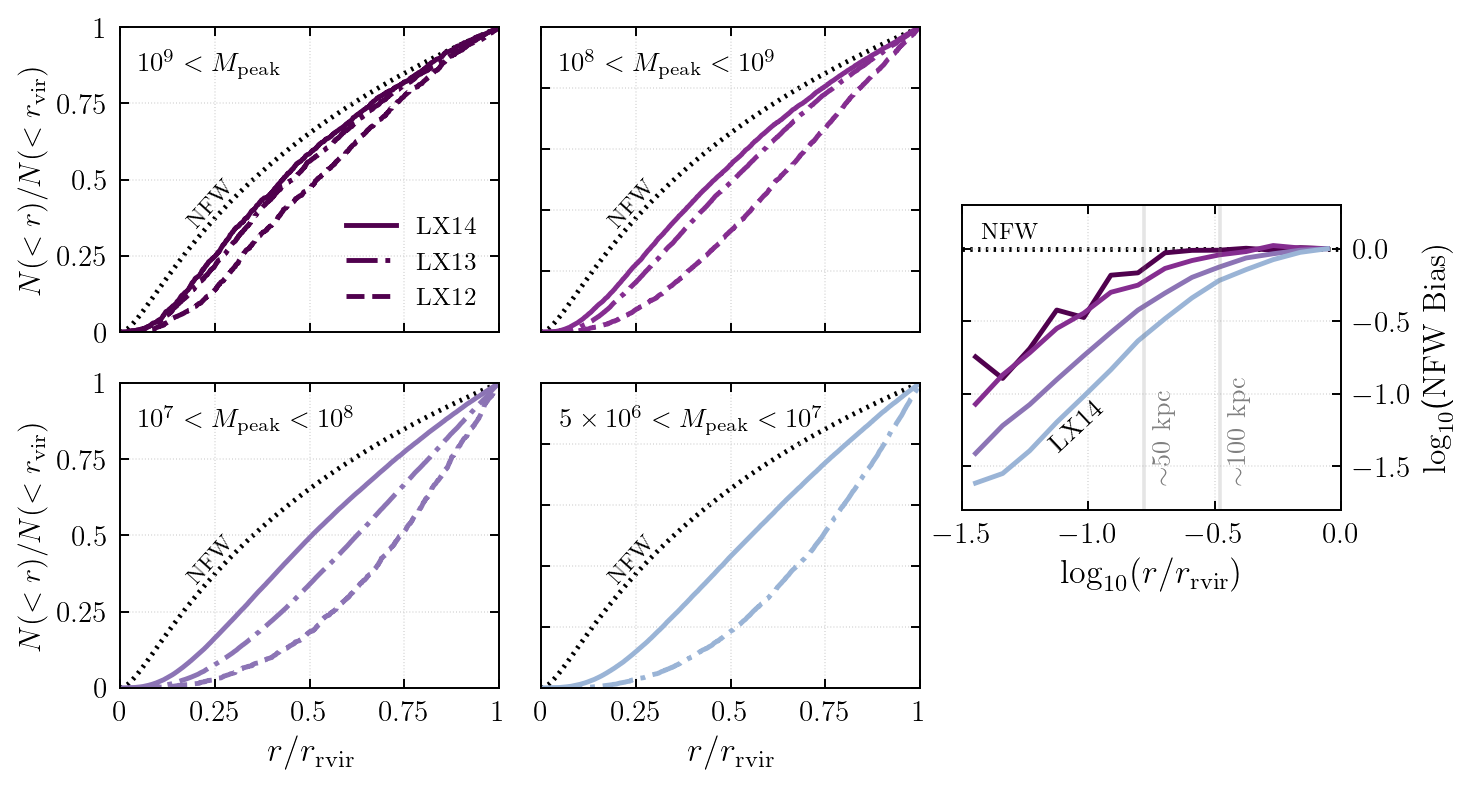

In [228]:

import matplotlib

cmap = matplotlib.cm.get_cmap('BuPu')



import matplotlib.gridspec as gridspec

fig,ax = plt.subplots(1,1,figsize = (9,5))
plt.subplots_adjust(wspace = 1.2,hspace = 1)
gs = gridspec.GridSpec(4,6,wspace = 0.25,hspace = 0.4,figure=fig)


ax1 = plt.subplot(gs[0:2,0:2])
ax2 = plt.subplot(gs[0:2,2:4])
ax3 = plt.subplot(gs[2:4,2:4])
ax4 = plt.subplot(gs[2:4,0:2])
ax5 = plt.subplot(gs[1:3,4:6])

all_axes = [ax1,ax2,ax3,ax4,ax5]


for axi in all_axes:
    axi.tick_params(axis = "x",labelsize = 12)
    axi.tick_params(axis = "y",labelsize = 12)
    axi.grid(ls=":",color = "lightgrey",alpha = 0.7)
    axi.yaxis.set_ticks_position('both')
    axi.xaxis.set_ticks_position('both')
    
    
ax1.text(0.17,0.34,r"\rm NFW",fontsize = 9.5,rotation = 48)
ax2.text(0.17,0.34,r"\rm NFW",fontsize = 9.5,rotation = 48)
ax3.text(0.17,0.34,r"\rm NFW",fontsize = 9.5,rotation = 48)
ax4.text(0.17,0.34,r"\rm NFW",fontsize = 9.5,rotation = 48)

        
rtr = np.linspace(0,1,100)
cat14_nfw = nfw_fx(rtr*np.mean(cat14_host_conces))
ax1.plot(rtr,cat14_nfw/np.max(cat14_nfw),color = "k",lw = 2,ls = "dotted",zorder = 0)
ax2.plot(rtr,cat14_nfw/np.max(cat14_nfw),color = "k",lw = 2,ls = "dotted",zorder = 0)
ax3.plot(rtr,cat14_nfw/np.max(cat14_nfw),color = "k",lw = 2,ls = "dotted",zorder = 0)
ax4.plot(rtr,cat14_nfw/np.max(cat14_nfw),color = "k",lw = 2,ls = "dotted",zorder = 0)


plot_average(cat12_x_9m,ax1,color = cmap(0.99),lw = 2,ls="--")
plot_average(cat13_x_9m,ax1,color = cmap(0.99),lw = 2,ls = "-.")
plot_average(cat14_x_9m,ax1,color = cmap(0.99),lw = 2,ls = "-")
ax1.text(0.05,0.855,r"\rm $10^9 < M_{\rm peak} $",fontsize = 11)
ax1.set_xlim([0,1])
ax1.set_ylim([0,1])
ax1.set_xticklabels([])
ax1.set_ylabel(r"\rm $N(<r)/N(<r_{\rm vir})$",fontsize = 12.5)
ax1.set_yticks([0,0.25,0.5,0.75,1])
ax1.set_yticklabels(["$0$","$0.25$","$0.5$","$0.75$","$1$"])

legend_elements = [Line2D([0], [0], color=cmap(0.99), lw=2,ls = "-",label = r'\rm LX14'),
                   Line2D([0], [0], color=cmap(0.99), lw=2,ls = "-.",label = r'\rm LX13'),
                   Line2D([0], [0], color=cmap(0.99), lw=2,ls = "--",label = r'\rm LX12')]

ax1.legend(handles=legend_elements, loc='lower right',frameon=False,fontsize =10.4)



plot_average(cat12_x_8_9,ax2,color = cmap(0.8),lw = 2,ls="--")
plot_average(cat13_x_8_9,ax2,color = cmap(0.8),lw = 2,ls = "-.")
plot_average(cat14_x_8_9,ax2,color = cmap(0.8),lw = 2,ls = "-")
ax2.text(0.05,0.855,r"\rm $10^8 < M_{\rm peak} < 10^9$",fontsize = 11)
ax2.set_xlim([0,1])
ax2.set_ylim([0,1])
ax2.set_xticklabels([])
ax2.set_yticklabels([])




plot_average(cat12_x_7_8,ax4,color = cmap(0.6),lw = 2,ls="--")
plot_average(cat13_x_7_8,ax4,color = cmap(0.6),lw = 2,ls = "-.")
plot_average(cat14_x_7_8,ax4,color = cmap(0.6),lw = 2,ls = "-")
ax4.text(0.05,0.855,r"\rm $10^7 < M_{\rm peak} < 10^8$",fontsize = 11)
ax4.set_xlim([0,1])
ax4.set_ylim([0,1])
ax4.set_ylabel(r"\rm $N(<r)/N(<r_{\rm vir})$",fontsize = 12.5)
ax4.set_xlabel(r"$r/r_{\rm rvir}$",fontsize = 14)
ax4.set_xticklabels(["$0$","$0.25$","$0.5$","$0.75$","$1$"])
ax4.set_yticks([0,0.25,0.5,0.75,1])
ax4.set_yticklabels(["$0$","$0.25$","$0.5$","$0.75$","$1$"])




# plot_average(cat12_x_65_7,ax3,color = cmap(0.4),lw = 2,ls="-.")
plot_average(cat13_x_65_7,ax3,color = cmap(0.4),lw = 2,ls = "-.")
plot_average(cat14_x_65_7,ax3,color = cmap(0.4),lw = 2,ls = "-")
ax3.text(0.05,0.855,r"\rm $5\times 10^6 < M_{\rm peak} < 10^{7}$",fontsize = 11)
ax3.set_xlim([0,1])
ax3.set_ylim([0,1])
ax3.set_yticklabels([])
ax3.set_xticklabels(["$0$","$0.25$","$0.5$","$0.75$","$1$"])


ax3.set_xlabel(r"$r/r_{\rm rvir}$",fontsize = 14)


plot_average_log(cat14_x_9m, np.mean(cat14_host_conces),ax5,color = cmap(0.99),lw = 2,nbins = 15,contours=False)
plot_average_log(cat14_x_8_9, np.mean(cat14_host_conces),ax5,color = cmap(0.8),lw = 2,nbins = 15,contours=False)
plot_average_log(cat14_x_7_8, np.mean(cat14_host_conces),ax5,color = cmap(0.6),lw = 2,nbins = 15,contours=False)
plot_average_log(cat14_x_65_7, np.mean(cat14_host_conces),ax5,color = cmap(0.4),lw = 2,nbins = 15,contours=False)


ax5.vlines(x = np.log10(50/300),ymin = -2,ymax = 0.5,color = "grey" ,alpha = 0.2)
ax5.vlines(x = np.log10(100/300),ymin = -2,ymax = 0.5,color = "grey" ,alpha = 0.2,ls = "-")

ax5.text(-1.425,0.07,r"\rm NFW",fontsize = 9.5)


ax5.text(-1.17,-1.4,r"\rm LX14",fontsize = 11,rotation =43)



ax5.plot([-1.5,0],[0,0],color = "k",ls = "dotted",lw = 2,zorder = 0)
ax5.set_xlim([-1.5,0])
ax5.set_ylim([-2,0.4])

ax5.text(-0.75,-1.6,r"\rm $\sim$50 kpc",rotation = 90,fontsize=10.8,color = "grey")
ax5.text(-0.45,-1.6,r"\rm $\sim$100 kpc",rotation = 90,fontsize=10.8,color = "grey")
ax5.set_xlabel(r"$\log_{10}(r/r_{\rm rvir})$",fontsize = 14)
ax5.set_ylabel(r"$\log_{10}$(\rm NFW Bias)",fontsize = 13)
ax5.yaxis.set_label_position("right")
ax5.yaxis.tick_right()
ax5.set_ylim([-1.8,0.3])
# ax5.set_yticks([-2,-1.5,-1,-0.5,0])
ax5.yaxis.set_ticks_position('both')



plt.show()





## G) Subhalo mass function and Host MAHs

In [240]:
def plot_shmf(mpeaks,host_mass,ax,color="mediumblue",lw=2,ls="-",grey=False,median=True):
    
    phat_x = []
    
    if len(mpeaks) != len(host_mass):
        print("ISSUE WITH ARRAY LENGHTS")

        
    for i in range(len(mpeaks)):
        phat_x.append(np.sort(mpeaks[i])/host_mass[i])
        if grey == True:
            ax.plot(np.sort(mpeaks[i])/host_mass[i],np.arange(1,len(mpeaks[i])+1)[::-1],color = "grey",lw=0.5,alpha = 0.5,zorder = 0)
            
    phat_x = np.concatenate(phat_x)
    if median == True:
        ax.plot(np.sort(phat_x),np.arange(1,len(phat_x)+1)[::-1]/len(mpeaks),color = color,lw=lw,ls = ls)

    return




In [242]:
cat12_host_mass = []
cat12_subs_all = []
cat12_subs_100 = []
cat12_subs_50 = []
cat12_dists_all = []
cat12_hosts_rvir = []
cat12_host_conces = []


for i in range(len(lx12_cats)):
    dfi = pd.read_csv(lx12_cats[i])

    mpeak = np.array(dfi["mvir_peak"])
    rvir = np.array(dfi["rvir"])
    rs = np.array(dfi["rs"])
    hdists = np.array(dfi["hdist"])
    
    cat12_host_mass.append(mpeak[0])
    cat12_hosts_rvir.append(rvir[0])
    cat12_host_conces.append(rvir[0]/rs[0])
    cat12_dists_all.append(hdists[(hdists > 0) & (hdists < rvir[0])])

    mpeak_subs_all = mpeak[(hdists > 0) & (hdists < rvir[0])]
    mpeak_subs_100 = mpeak[(hdists > 0) & (hdists < 100)]
    mpeak_subs_50 = mpeak[(hdists > 0) & (hdists < 50)]
    
    cat12_subs_all.append(mpeak_subs_all)
    cat12_subs_100.append(mpeak_subs_100)
    cat12_subs_50.append(mpeak_subs_50)

    print(len(mpeak_subs_all))
#     print("--"*10)

print("---------------------------------------------")

cat13_host_mass = []
cat13_subs_all = []
cat13_subs_100 = []
cat13_subs_50 = []
cat13_dists_all = []
cat13_hosts_rvir = []
cat13_host_conces = []

for i in range(len(lx13_cats)):
    dfi = pd.read_csv(lx13_cats[i])

    mpeak = np.array(dfi["mvir_peak"])
    rvir = np.array(dfi["rvir"])
    rs = np.array(dfi["rs"])
    hdists = np.array(dfi["hdist"])

    cat13_host_mass.append(mpeak[0])
    cat13_hosts_rvir.append(rvir[0])
    cat13_host_conces.append(rvir[0]/rs[0])
    
    cat13_dists_all.append(hdists[(hdists > 0) & (hdists < rvir[0])])

    mpeak_subs_all = mpeak[(hdists > 0) & (hdists < rvir[0])]
    mpeak_subs_100 = mpeak[(hdists > 0) & (hdists < 100)]
    mpeak_subs_50 = mpeak[(hdists > 0) & (hdists < 50)]
    
    cat13_subs_all.append(mpeak_subs_all)
    cat13_subs_100.append(mpeak_subs_100)
    cat13_subs_50.append(mpeak_subs_50)

    print(len(mpeak_subs_all))
#     print("--"*10)
    
print("---------------------------------------------")
cat14_host_mass = []
cat14_subs_all = []
cat14_subs_100 = []
cat14_subs_50 = []
cat14_dists_all = []
cat14_hosts_rvir = []
cat14_host_conces = []

for i in range(len(lx14_cats)):
    dfi = pd.read_csv(lx14_cats[i])

    mpeak = np.array(dfi["mvir_peak"])
    rvir = np.array(dfi["rvir"])
    rs = np.array(dfi["rs"])
    
    cat14_host_conces.append(rvir[0]/rs[0])

    hdists = np.array(dfi["hdist"])

    cat14_host_mass.append(mpeak[0])
    cat14_hosts_rvir.append(rvir[0])

    cat14_dists_all.append(hdists[(hdists > 0) & (hdists < rvir[0])])

    mpeak_subs_all = mpeak[(hdists > 0) & (hdists < rvir[0])]
    mpeak_subs_100 = mpeak[(hdists > 0) & (hdists < 100)]
    mpeak_subs_50 = mpeak[(hdists > 0) & (hdists < 50)]
    
    cat14_subs_all.append(mpeak_subs_all)
    cat14_subs_100.append(mpeak_subs_100)
    cat14_subs_50.append(mpeak_subs_50)

    print(len(mpeak_subs_all))
#     print("--"*10)


cat14_subs_all = np.array(cat14_subs_all)
cat14_host_mass = np.array(cat14_host_mass)




179
288
271
300
256
172
252
205
278
251
310
213
339
280
239
161
269
261
241
187
219
149
254
233
251
213
323
282
214
142
155
195
---------------------------------------------
1144
2031
2078
1819
2031
1158
1866
1602
1880
1849
2145
1615
2492
1921
1560
1333
2008
1815
2270
1661
1577
959
1845
1667
1871
1720
2670
1986
1895
1010
1236
1543
---------------------------------------------
8079
14696
14505
13510
14052
8440
13074
12021
13250
12750
15310
11569
17243
13267
11342
10277
14234
12477
16347
12415
10979
6532
13688
11857
12978
12839
17839
14101
13352
6919
8523
11398


/Users/radioactive/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


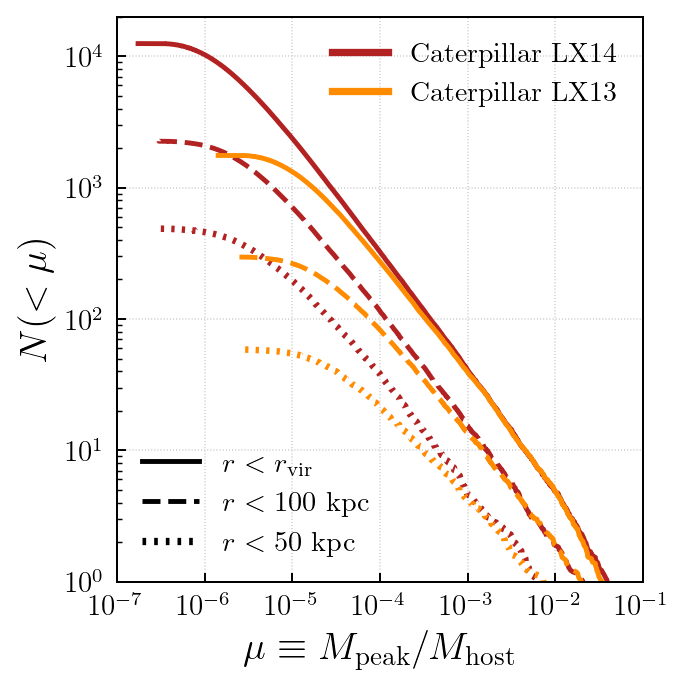

In [243]:
fig,ax = plt.subplots(1,1,figsize = (4,4))

plt.subplots_adjust(wspace = 0.1)

plot_shmf(cat14_subs_50,cat14_host_mass,ax,color="firebrick",lw=2.7,ls="dotted")
plot_shmf(cat13_subs_50,cat13_host_mass,ax,color="darkorange",lw=2.7,ls="dotted")
# plot_shmf(cat12_subs_50,cat12_host_mass,ax,color="darkmagenta",lw=2.7,ls="dotted")

plot_shmf(cat14_subs_100,cat14_host_mass,ax,color="firebrick",lw=2,ls="--")
plot_shmf(cat13_subs_100,cat13_host_mass,ax,color="darkorange",lw=2,ls="--")
# plot_shmf(cat12_subs_100,cat12_host_mass,ax,color="darkmagenta",lw=2,ls="--")

plot_shmf(cat14_subs_all,cat14_host_mass,ax,color="firebrick",lw=2,ls="-")
plot_shmf(cat13_subs_all,cat13_host_mass,ax,color="darkorange",lw=2,ls="-")
# plot_shmf(cat12_subs_all,cat12_host_mass,ax,color="darkmagenta",lw=2,ls="-")

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylim([1,2e4])

ax.set_xlim([1e-7,1e-1])
ax.grid(ls = ":",color = "lightgrey")

ax.tick_params(axis = "x",labelsize = 12)
ax.tick_params(axis = "y",labelsize = 12)

ax.set_xticks([1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1])

ax.set_xlabel(r"$\mu \equiv M_{\rm peak}/M_{\rm host}$",fontsize = 16)
ax.set_ylabel(r"$N(<\mu)$",fontsize = 16)

# ax.vlines(x = 4e-6,ymin = 1,ymax = 1e4,color = "cadetblue",ls = "dotted")

legend_elements_2 = [Line2D([0], [0], color='firebrick', lw=3,ls = "-",label=r'\rm Caterpillar LX14'),
                Line2D([0], [0], color='darkorange', lw=3,ls = "-",label=r'\rm Caterpillar LX13')]
#                      Line2D([0], [0], color='darkmagenta', lw=3,ls = "-",label=r'\rm Caterpillar LX12')]


ax.legend(handles=legend_elements_2, loc='upper right',frameon=False,fontsize =11.5)


legend_elements = [Line2D([0], [0], color='k', lw=2,ls = "-",label=r'\rm $r < r_{\rm vir}$'),
                     Line2D([0], [0], color='k', lw=2,ls = "--",label=r'\rm $r < 100$ kpc'),
                     Line2D([0], [0], color='k', lw=3,ls = "dotted",label=r'\rm $r < 50$ kpc')]
                      
ax2 = ax.twinx()
ax2.get_yaxis().set_visible(False)
ax2.legend(handles=legend_elements, loc='lower left',frameon=False,fontsize =11.7)

plt.tight_layout()

# plt.savefig("cat_res_plot.pdf")

plt.show()

In [278]:

for i,li in enumerate(lx14_cats):
    if "caterpillar_53_catalog" in li:
        ind_53 = i
    if "caterpillar_4_catalog" in li:
        ind_4 = i

print(ind_53,ind_4)

###########################

all_host_tracks = glob.glob(data_path + "/caterpillar_outputs/all_host_evos/*.csv")


all_m200c_lmc = []
all_ts_lmc = []


all_m200c_lmc_late = []
all_ts_lmc_late = []

all_m200c_nolmc = []
all_ts_nolmc = []

for i,hi in enumerate(all_host_tracks):
    dfi = pd.read_csv(all_host_tracks[i])
    m200c = np.array(dfi["M200c"])
    t = np.array(dfi["t"])
    
    if "caterpillar_53_" in hi or "caterpillar_4_" in hi:
        print(hi)
        all_ts_lmc.append(t)
        all_m200c_lmc.append( m200c/m200c[-1] )
        
    #1 (c), 27 (c) , 40 (c),  6 (c)
#     elif "caterpillar_1_" in hi or "caterpillar_27_" in hi or "caterpillar_40_" in hi or "caterpillar_6_" in hi:
#         all_ts_lmc_late.append(t)
#         all_m200c_lmc_late.append( m200c/m200c[-1] )
    else:
        all_ts_nolmc.append(t)
        all_m200c_nolmc.append( m200c/m200c[-1] )
    

24 6
/Volumes/minions/random_explore/caterpillar_outputs/all_host_evos/caterpillar_53_LX14_a_1.00_0_0_track.csv
/Volumes/minions/random_explore/caterpillar_outputs/all_host_evos/caterpillar_4_LX14_a_1.00_0_0_track.csv


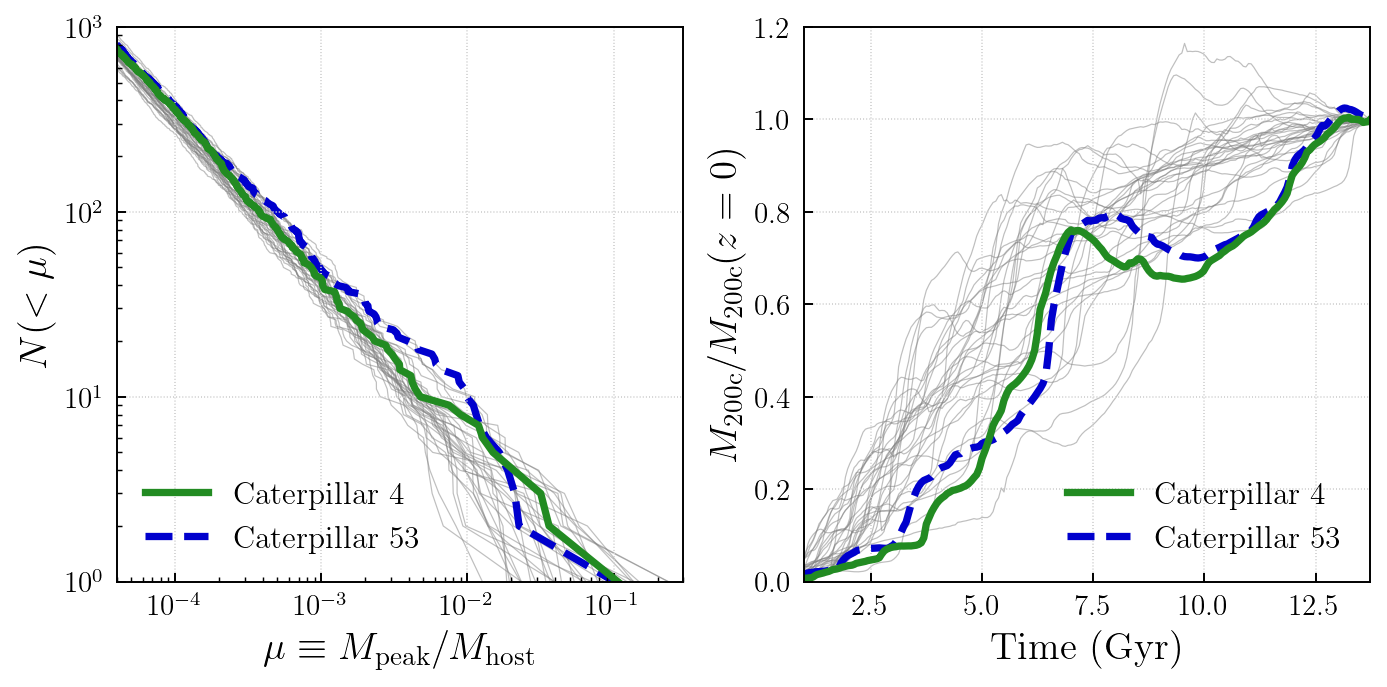

In [279]:
lmc_colors = ["mediumblue","forestgreen"]


fig,ax = plt.subplots(1,2,figsize = (8,4))

plt.subplots_adjust(wspace = 0.1)

sub53_all = cat14_subs_all[ind_53]
sub53_host_mass = cat14_host_mass[ind_53]

sub4_all = cat14_subs_all[ind_4]
sub4_host_mass = cat14_host_mass[ind_4]


plot_shmf(cat14_subs_all,cat14_host_mass,ax[0],color="firebrick",lw=3,ls="-",grey=True,median=False)

ax[0].plot(np.sort(sub4_all)/sub4_host_mass,np.arange(1,len(sub4_all)+1)[::-1],color = "forestgreen",lw=3,alpha = 1,label=r'\rm Caterpillar 4',zorder = 2)
ax[0].plot(np.sort(sub53_all)/sub53_host_mass,np.arange(1,len(sub53_all)+1)[::-1],color = "mediumblue",lw=3,alpha = 1,label=r'\rm Caterpillar 53',zorder = 1,ls = "--")

ax[0].legend(loc='lower left',frameon=False,fontsize =13)


ax[0].set_xscale("log")
ax[0].set_yscale("log")
ax[0].set_ylim([1,1e3])

ax[0].grid(ls = ":",color = "lightgrey")

ax[0].tick_params(axis = "x",labelsize = 12)
ax[0].tick_params(axis = "y",labelsize = 12)
ax[0].set_xlim([4e-5,3e-1])

ax[0].set_xticks([1e-4,1e-3,1e-2,1e-1])

ax[0].set_xlabel(r"$\mu \equiv M_{\rm peak}/M_{\rm host}$",fontsize = 16)

ax[0].set_ylabel(r"$N(<\mu)$",fontsize = 16)

#########



# host_names = [r"\rm Caterpillar 24",r"\rm Caterpillar 53",r"\rm Caterpillar 4" ]
#the order is 24, 53, and 4


legend_elements_2 = [Line2D([0], [0], color='forestgreen', lw=3,ls = "-",label=r'\rm Caterpillar 4'),
                     Line2D([0], [0], color='mediumblue', lw=3,ls = "--",label=r'\rm Caterpillar 53')]


ax[1].legend(handles=legend_elements_2, loc='lower right',frameon=False,fontsize =13)


# for k in range(len(all_ts_lmc)):
ax[1].plot(all_ts_lmc[0],all_m200c_lmc[0],zorder =2,color = lmc_colors[0],lw =3,ls = "--")
ax[1].plot(all_ts_lmc[1],all_m200c_lmc[1],zorder =2,color = lmc_colors[1],lw =3)

    
# for k in range(len(all_ts_lmc_late)):
#     ax.plot(all_ts_lmc_late[k],all_m200c_lmc_late[k],zorder =2,color = 'k',lw =0.5)
    
    
for k in range(len(all_ts_nolmc)):
    if k == 0:
        ax[1].plot(all_ts_nolmc[k],all_m200c_nolmc[k],color ="grey",zorder = 1,lw = 0.5,alpha = 0.5)
    else:
        ax[1].plot(all_ts_nolmc[k],all_m200c_nolmc[k],color ="grey",zorder = 1,lw = 0.5,alpha = 0.5)
    

    
    
ax[1].set_xlim([1,all_ts_nolmc[0][-1]])
ax[1].set_ylim([0,1.2])

ax[1].grid(ls = ":",color = "lightgrey")


ax[1].tick_params(axis = "x",labelsize = 12)
ax[1].tick_params(axis = "y",labelsize = 12)

ax[1].set_ylabel(r"$M_{\rm 200c}/M_{\rm 200c}(z=0)$",fontsize = 16)
ax[1].set_xlabel(r"\rm Time (Gyr)",fontsize = 16)


plt.tight_layout()

# plt.savefig("/Users/radioactive/Desktop/PROJS/paper2/paper_figs_cater_pdf/cater_sums_plot.pdf")
# plt.savefig("cater_sums_plot.pdf")


plt.show()

